<a href="https://colab.research.google.com/github/dyna478/Paz/blob/main/TSP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install python_tsp

In [ ]:
pip install ortools

Hybrid TSP Solver with OR-Tools - Advanced Implementation
Example 1: Small Random Instance (30 cities)
Applying OR-Tools optimization...
Best solution found:
  Distance: 4813.84
  Optimal k: 3
  Computation time: 0.29s
  Tour length: 30
  Post-optimization improvement: 0.00



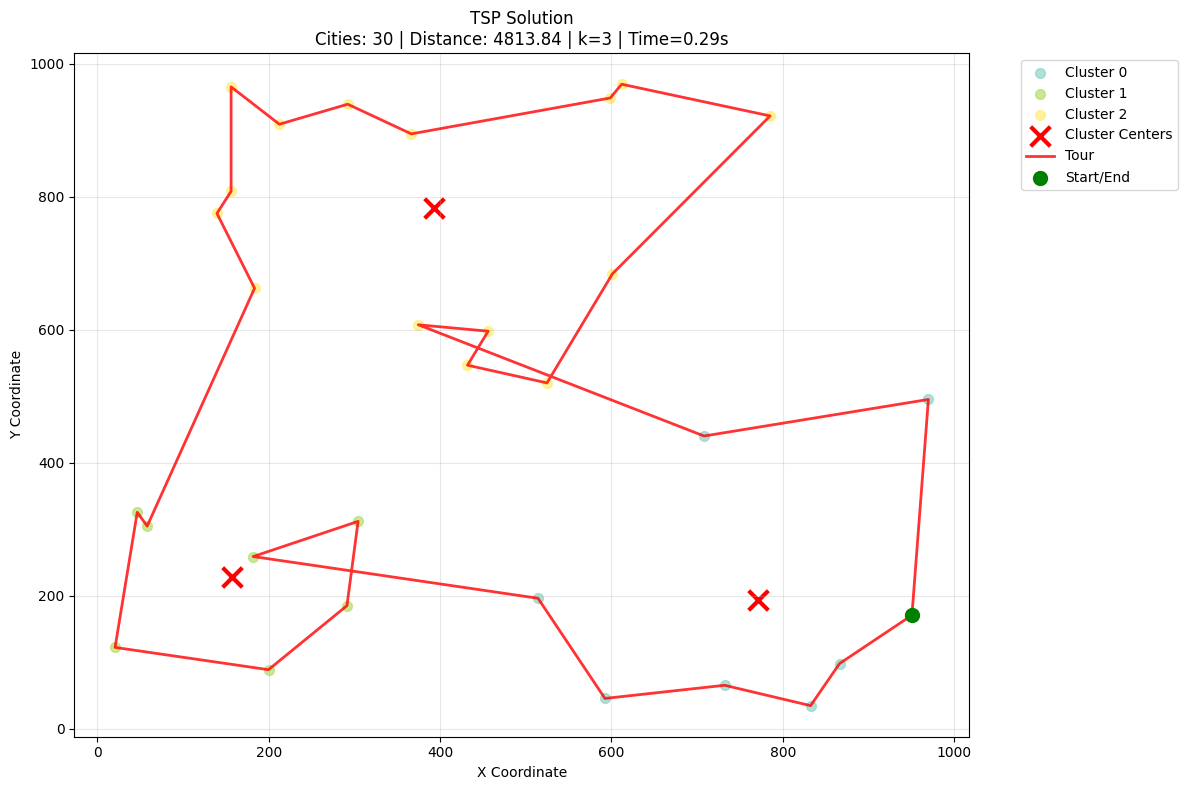


Sub-problem metrics:
Number of sub-problems: 3
Average sub-problem distance: 1455.25
Max sub-problem distance: 1925.42
Example 2: Comparing with and without OR-Tools
Applying OR-Tools optimization...
Without OR-Tools:
  Distance: 6740.33
  Computation time: 1.04s

With OR-Tools:
  Distance: 7252.42
  Computation time: 0.41s
  Improvement: -512.09 (-7.60%)

Example 3: Benchmark with OR-Tools
Running benchmark 1/2: random_uniform_20
  Run 1/1
Applying OR-Tools optimization...
  Best distance: 3529.65
  Average distance: 3529.65

Running benchmark 2/2: random_uniform_50
  Run 1/1
Applying OR-Tools optimization...
  Best distance: 7252.42
  Average distance: 7252.42

Benchmark Summary:

random_uniform_20:
  Cities: 20
  Best distance: 3529.65
  Best k: 6
  Average time: 0.08s

random_uniform_50:
  Cities: 50
  Best distance: 7252.42
  Best k: 6
  Average time: 0.41s


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.optimize import differential_evolution, minimize
import random
import itertools
import sys
import time
import os
import warnings
from typing import List, Tuple, Dict, Optional, Union
from dataclasses import dataclass
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import multiprocessing as mp
from functools import partial
import json
import pickle

# Add OR-Tools import
try:
    from ortools.constraint_solver import routing_enums_pb2
    from ortools.constraint_solver import pywrapcp
    ORTOOLS_AVAILABLE = True
except ImportError:
    ORTOOLS_AVAILABLE = False
    print("Warning: OR-Tools not available. Install with 'pip install ortools' for better solutions.")

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

# --- Configuration Classes ---
@dataclass
class TSPConfig:
    """Configuration class for TSP solver parameters"""
    # Clustering parameters
    k_values_to_test: List[int] = None
    kmeans_n_init: Union[str, int] = 'auto'
    kmeans_random_state: int = 42
    use_adaptive_k: bool = True
    max_k_ratio: float = 0.3  # Maximum k as ratio of total cities

    # SFLA parameters
    sfla_population_size: int = 50
    sfla_max_iterations: int = 100
    sfla_memeplex_count: int = 5
    sfla_local_search_iterations: int = 10
    sfla_mutation_rate: float = 0.1
    sfla_elite_ratio: float = 0.2

    # Optimization parameters
    use_2opt: bool = True
    use_3opt: bool = True
    use_or_opt: bool = True
    lin_kernighan_iterations: int = 1000

    # Merge strategy parameters
    merge_strategy: str = 'advanced_prim'  # 'simple', 'prim', 'advanced_prim', 'genetic'
    num_merge_candidates: int = 5
    use_merge_optimization: bool = True

    # Performance parameters
    use_parallel_processing: bool = True
    max_workers: int = min(8, mp.cpu_count())

    # Validation parameters
    known_optimum: Optional[float] = None
    benchmark_name: str = "unknown"

    # OR-Tools parameters
    use_ortools: bool = True
    ortools_time_limit_ms: int = 5000
    ortools_solution_limit: int = 10

    def __post_init__(self):
        if self.k_values_to_test is None:
            self.k_values_to_test = [2, 3, 4, 5, 6, 7, 8]

@dataclass
class TSPResult:
    """Result container for TSP solutions"""
    k: int
    tour: List[int]
    distance: float
    optimality_gap: float
    computation_time: float
    cluster_labels: np.ndarray
    cluster_centers: np.ndarray
    sub_problems_distances: List[float]
    merge_distance_improvement: float
    post_optimization_improvement: float

    def to_dict(self) -> Dict:
        return {
            'k': self.k,
            'distance': self.distance,
            'optimality_gap': self.optimality_gap,
            'computation_time': self.computation_time,
            'tour_length': len(self.tour),
            'avg_subproblem_distance': np.mean(self.sub_problems_distances) if self.sub_problems_distances else 0,
            'merge_improvement': self.merge_distance_improvement,
            'post_opt_improvement': self.post_optimization_improvement
        }

class TSPDataLoader:
    """Advanced data loader for various TSP formats"""

    @staticmethod
    def load_from_csv(filepath: str, delimiter: str = None) -> Tuple[np.ndarray, np.ndarray, pd.DataFrame]:
        """Load TSP data from CSV file with automatic format detection"""
        try:
            # Try different delimiters
            delimiters = [delimiter] if delimiter else [',', ' ', '\t', ';']

            for delim in delimiters:
                try:
                    df = pd.read_csv(filepath, delimiter=delim, header=None)

                    # Handle different column formats
                    if df.shape[1] >= 3:  # id, x, y format
                        df.columns = ['id', 'x', 'y'] + [f'col_{i}' for i in range(3, df.shape[1])]
                    elif df.shape[1] == 2:  # x, y format
                        df.columns = ['x', 'y']
                        df.insert(0, 'id', range(len(df)))
                    else:
                        continue

                    # Clean and validate data
                    df['x'] = pd.to_numeric(df['x'], errors='coerce')
                    df['y'] = pd.to_numeric(df['y'], errors='coerce')
                    df = df.dropna(subset=['x', 'y'])

                    if len(df) > 0:
                        coordinates = df[['x', 'y']].to_numpy()
                        ids = df['id'].to_numpy() if 'id' in df.columns else np.arange(len(df))
                        return coordinates, ids, df

                except Exception:
                    continue

            raise ValueError(f"Could not parse file {filepath} with any delimiter")

        except Exception as e:
            raise ValueError(f"Error loading data from {filepath}: {str(e)}")

    @staticmethod
    def load_tsplib_format(filepath: str) -> Tuple[np.ndarray, np.ndarray, pd.DataFrame]:
        """Load data from TSPLIB format files"""
        coordinates = []

        with open(filepath, 'r') as f:
            lines = f.readlines()

        # Find NODE_COORD_SECTION
        start_idx = None
        for i, line in enumerate(lines):
            if 'NODE_COORD_SECTION' in line:
                start_idx = i + 1
                break

        if start_idx is None:
            raise ValueError("NODE_COORD_SECTION not found in file")

        # Parse coordinates
        for line in lines[start_idx:]:
            if line.strip() == 'EOF' or line.strip() == '':
                break
            parts = line.strip().split()
            if len(parts) >= 3:
                try:
                    node_id = int(parts[0])
                    x = float(parts[1])
                    y = float(parts[2])
                    coordinates.append([node_id, x, y])
                except ValueError:
                    continue

        if not coordinates:
            raise ValueError("No valid coordinates found")

        df = pd.DataFrame(coordinates, columns=['id', 'x', 'y'])
        coords = df[['x', 'y']].to_numpy()
        ids = df['id'].to_numpy()

        return coords, ids, df

    @staticmethod
    def generate_random_instance(n_cities: int, width: float = 1000, height: float = 1000,
                                distribution: str = 'uniform', seed: int = 42) -> Tuple[np.ndarray, np.ndarray, pd.DataFrame]:
        """Generate random TSP instance for testing"""
        np.random.seed(seed)

        if distribution == 'uniform':
            x = np.random.uniform(0, width, n_cities)
            y = np.random.uniform(0, height, n_cities)
        elif distribution == 'clustered':
            # Create clustered distribution
            n_clusters = max(2, n_cities // 10)
            cluster_centers = np.random.uniform([width*0.2, height*0.2], [width*0.8, height*0.8], (n_clusters, 2))

            x, y = [], []
            cities_per_cluster = n_cities // n_clusters

            for i, center in enumerate(cluster_centers):
                if i == len(cluster_centers) - 1:  # Last cluster gets remaining cities
                    n_in_cluster = n_cities - len(x)
                else:
                    n_in_cluster = cities_per_cluster

                # Generate cities around cluster center
                cluster_x = np.random.normal(center[0], width*0.1, n_in_cluster)
                cluster_y = np.random.normal(center[1], height*0.1, n_in_cluster)

                x.extend(cluster_x)
                y.extend(cluster_y)

            x, y = np.array(x), np.array(y)
        else:
            raise ValueError(f"Unknown distribution: {distribution}")

        coordinates = np.column_stack([x, y])
        ids = np.arange(n_cities)
        df = pd.DataFrame({'id': ids, 'x': x, 'y': y})

        return coordinates, ids, df

class SFLAOptimizer:
    """Shuffled Frog Leaping Algorithm implementation for TSP"""

    def __init__(self, config: TSPConfig):
        self.config = config
        self.population_size = config.sfla_population_size
        self.max_iterations = config.sfla_max_iterations
        self.memeplex_count = config.sfla_memeplex_count
        self.local_iterations = config.sfla_local_search_iterations
        self.mutation_rate = config.sfla_mutation_rate
        self.elite_ratio = config.sfla_elite_ratio

    def solve(self, distance_matrix: np.ndarray) -> Tuple[List[int], float]:
        """Solve TSP using SFLA algorithm"""
        n_cities = len(distance_matrix)

        if n_cities <= 2:
            return list(range(n_cities)), 0 if n_cities <= 1 else distance_matrix[0, 1] * 2

        # Initialize population
        population = self._initialize_population(n_cities)

        # Evaluate initial population
        fitness_scores = [self._evaluate_tour(tour, distance_matrix) for tour in population]

        best_tour = None
        best_distance = float('inf')

        for iteration in range(self.max_iterations):
            # Sort population by fitness
            sorted_indices = np.argsort(fitness_scores)
            population = [population[i] for i in sorted_indices]
            fitness_scores = [fitness_scores[i] for i in sorted_indices]

            # Update best solution
            if fitness_scores[0] < best_distance:
                best_distance = fitness_scores[0]
                best_tour = population[0].copy()

            # Divide into memeplexes
            memeplexes = self._divide_into_memeplexes(population, fitness_scores)

            # Local search within each memeplex
            new_population = []
            new_fitness = []

            for memeplex, memeplex_fitness in memeplexes:
                improved_memeplex, improved_fitness = self._local_search(
                    memeplex, memeplex_fitness, distance_matrix
                )
                new_population.extend(improved_memeplex)
                new_fitness.extend(improved_fitness)

            population = new_population
            fitness_scores = new_fitness

            # Apply mutation
            population, fitness_scores = self._apply_mutation(population, fitness_scores, distance_matrix)

            # Early stopping if no improvement
            if iteration > 20 and abs(fitness_scores[0] - best_distance) < 1e-6:
                break

        return best_tour, best_distance

    def _initialize_population(self, n_cities: int) -> List[List[int]]:
        """Initialize population with diverse tours"""
        population = []

        # Add greedy tour
        greedy_tour = self._nearest_neighbor_tour(n_cities)
        population.append(greedy_tour)

        # Add random tours
        for _ in range(self.population_size - 1):
            tour = list(range(n_cities))
            np.random.shuffle(tour)
            population.append(tour)

        return population

    def _nearest_neighbor_tour(self, n_cities: int) -> List[int]:
        """Generate nearest neighbor tour as good starting point"""
        unvisited = set(range(1, n_cities))
        tour = [0]
        current = 0

        while unvisited:
            nearest = min(unvisited, key=lambda x: np.random.random())  # Add randomness
            tour.append(nearest)
            unvisited.remove(nearest)
            current = nearest

        return tour

    def _evaluate_tour(self, tour: List[int], distance_matrix: np.ndarray) -> float:
        """Calculate tour distance"""
        distance = 0
        for i in range(len(tour)):
            j = (i + 1) % len(tour)
            distance += distance_matrix[tour[i], tour[j]]
        return distance

    def _divide_into_memeplexes(self, population: List[List[int]], fitness_scores: List[float]) -> List[Tuple[List[List[int]], List[float]]]:
        """Divide population into memeplexes"""
        memeplexes = []
        pop_size = len(population)
        memeplex_size = pop_size // self.memeplex_count

        for i in range(self.memeplex_count):
            start_idx = i * memeplex_size
            if i == self.memeplex_count - 1:  # Last memeplex gets remaining
                end_idx = pop_size
            else:
                end_idx = (i + 1) * memeplex_size

            memeplex = population[start_idx:end_idx]
            memeplex_fitness = fitness_scores[start_idx:end_idx]
            memeplexes.append((memeplex, memeplex_fitness))

        return memeplexes

    def _local_search(self, memeplex: List[List[int]], fitness: List[float],
                     distance_matrix: np.ndarray) -> Tuple[List[List[int]], List[float]]:
        """Perform local search within memeplex"""
        for _ in range(self.local_iterations):
            # Select worst frog
            worst_idx = np.argmax(fitness)
            worst_tour = memeplex[worst_idx].copy()

            # Select best frog
            best_idx = np.argmin(fitness)
            best_tour = memeplex[best_idx]

            # Generate new solution by learning from best
            new_tour = self._generate_offspring(worst_tour, best_tour)
            new_fitness = self._evaluate_tour(new_tour, distance_matrix)

            # Replace if better
            if new_fitness < fitness[worst_idx]:
                memeplex[worst_idx] = new_tour
                fitness[worst_idx] = new_fitness

        return memeplex, fitness

    def _generate_offspring(self, parent1: List[int], parent2: List[int]) -> List[int]:
        """Generate offspring using order crossover (OX)"""
        n = len(parent1)

        # Select random segment from parent1
        start = np.random.randint(0, n)
        end = np.random.randint(start + 1, n + 1)

        # Copy segment from parent1
        offspring = [-1] * n
        offspring[start:end] = parent1[start:end]

        # Fill remaining positions with parent2's order
        remaining = [city for city in parent2 if city not in offspring]
        j = 0
        for i in range(n):
            if offspring[i] == -1:
                offspring[i] = remaining[j]
                j += 1

        return offspring

    def _apply_mutation(self, population: List[List[int]], fitness_scores: List[float],
                       distance_matrix: np.ndarray) -> Tuple[List[List[int]], List[float]]:
        """Apply mutation to population"""
        for i in range(len(population)):
            if np.random.random() < self.mutation_rate:
                # Apply 2-opt mutation
                tour = population[i].copy()
                tour = self._two_opt_mutation(tour)
                new_fitness = self._evaluate_tour(tour, distance_matrix)

                if new_fitness < fitness_scores[i]:
                    population[i] = tour
                    fitness_scores[i] = new_fitness

        return population, fitness_scores

    def _two_opt_mutation(self, tour: List[int]) -> List[int]:
        """Apply 2-opt mutation"""
        n = len(tour)
        if n < 4:
            return tour

        i = np.random.randint(0, n - 1)
        j = np.random.randint(i + 1, n)

        # Reverse segment between i and j
        new_tour = tour.copy()
        new_tour[i:j+1] = reversed(new_tour[i:j+1])

        return new_tour

class AdvancedLocalSearch:
    """Advanced local search optimization techniques"""

    def __init__(self, config: TSPConfig):
        self.config = config

    def optimize_tour(self, tour: List[int], distance_matrix: np.ndarray) -> Tuple[List[int], float]:
        """Apply multiple optimization techniques"""
        current_tour = tour.copy()
        current_distance = self._calculate_distance(current_tour, distance_matrix)

        improved = True
        iteration = 0
        max_iterations = self.config.lin_kernighan_iterations

        while improved and iteration < max_iterations:
            improved = False
            old_distance = current_distance

            # Apply 2-opt
            if self.config.use_2opt:
                current_tour, current_distance = self._two_opt(current_tour, distance_matrix)
                if current_distance < old_distance:
                    improved = True
                    old_distance = current_distance

            # Apply 3-opt
            if self.config.use_3opt and not improved:
                current_tour, current_distance = self._three_opt(current_tour, distance_matrix)
                if current_distance < old_distance:
                    improved = True
                    old_distance = current_distance

            # Apply Or-opt
            if self.config.use_or_opt and not improved:
                current_tour, current_distance = self._or_opt(current_tour, distance_matrix)
                if current_distance < old_distance:
                    improved = True

            iteration += 1

        return current_tour, current_distance

    def _calculate_distance(self, tour: List[int], distance_matrix: np.ndarray) -> float:
        """Calculate total tour distance"""
        distance = 0
        for i in range(len(tour)):
            j = (i + 1) % len(tour)
            distance += distance_matrix[tour[i], tour[j]]
        return distance

    def _two_opt(self, tour: List[int], distance_matrix: np.ndarray) -> Tuple[List[int], float]:
        """2-opt local search"""
        best_tour = tour.copy()
        best_distance = self._calculate_distance(best_tour, distance_matrix)
        n = len(tour)

        for i in range(n - 1):
            for j in range(i + 2, n):
                if j == n - 1 and i == 0:
                    continue  # Skip if it would just reverse the entire tour

                # Calculate distance change without creating new tour
                current_edges = (distance_matrix[tour[i], tour[i+1]] +
                               distance_matrix[tour[j], tour[(j+1) % n]])
                new_edges = (distance_matrix[tour[i], tour[j]] +
                           distance_matrix[tour[i+1], tour[(j+1) % n]])

                if new_edges < current_edges:
                    # Create new tour with reversed segment
                    new_tour = tour.copy()
                    new_tour[i+1:j+1] = reversed(new_tour[i+1:j+1])
                    new_distance = best_distance - current_edges + new_edges

                    if new_distance < best_distance:
                        best_tour = new_tour
                        best_distance = new_distance

        return best_tour, best_distance

    def _three_opt(self, tour: List[int], distance_matrix: np.ndarray) -> Tuple[List[int], float]:
        """3-opt local search (simplified version)"""
        best_tour = tour.copy()
        best_distance = self._calculate_distance(best_tour, distance_matrix)
        n = len(tour)

        if n < 6:
            return best_tour, best_distance

        # Sample some 3-opt moves to avoid O(n³) complexity
        num_samples = min(100, n * (n-1) // 6)

        for _ in range(num_samples):
            # Random 3-opt move
            indices = sorted(np.random.choice(n, 3, replace=False))
            i, j, k = indices

            # Try one of the 3-opt reconnections
            new_tour = (tour[:i+1] +
                       list(reversed(tour[j+1:k+1])) +
                       tour[i+1:j+1] +
                       tour[k+1:])

            new_distance = self._calculate_distance(new_tour, distance_matrix)

            if new_distance < best_distance:
                best_tour = new_tour
                best_distance = new_distance

        return best_tour, best_distance

    def _or_opt(self, tour: List[int], distance_matrix: np.ndarray) -> Tuple[List[int], float]:
        """Or-opt local search"""
        best_tour = tour.copy()
        best_distance = self._calculate_distance(best_tour, distance_matrix)
        n = len(tour)

        # Try relocating segments of length 1, 2, and 3
        for segment_length in [1, 2, 3]:
            if segment_length >= n:
                continue

            for i in range(n):
                if i + segment_length > n:
                    continue

                segment = tour[i:i+segment_length]
                remaining = tour[:i] + tour[i+segment_length:]

                # Try inserting segment at each position
                for j in range(len(remaining) + 1):
                    new_tour = remaining[:j] + segment + remaining[j:]
                    new_distance = self._calculate_distance(new_tour, distance_matrix)

                    if new_distance < best_distance:
                        best_tour = new_tour
                        best_distance = new_distance

        return best_tour, best_distance

class AdvancedClusterMerger:
    """Advanced cluster merging strategies"""

    def __init__(self, config: TSPConfig):
        self.config = config

    def merge_clusters(self, clusters_data: List[Dict], coordinates: np.ndarray) -> Tuple[List[int], float]:
        """Merge cluster tours using specified strategy"""
        # Validate input
        valid_clusters = [c for c in clusters_data if c.get('tour') and len(c['tour']) > 0]
        if not valid_clusters:
            raise ValueError("No valid clusters to merge")

        # Convert all tour indices to int
        for cluster in valid_clusters:
            cluster['tour'] = [int(x) for x in cluster['tour']]

        # If only one valid cluster, return its tour
        if len(valid_clusters) == 1:
            return valid_clusters[0]['tour'], self._calculate_tour_distance(valid_clusters[0]['tour'], coordinates)

        # Try different merge strategies
        best_tour = None
        best_distance = float('inf')

        try:
            if self.config.merge_strategy == 'simple':
                tour, distance = self._simple_merge(valid_clusters, coordinates)
            elif self.config.merge_strategy == 'prim':
                tour, distance = self._prim_merge(valid_clusters, coordinates)
            elif self.config.merge_strategy == 'advanced_prim':
                # Try each cluster as starting point
                for start_idx in range(len(valid_clusters)):
                    try:
                        tour, distance = self._simple_merge(valid_clusters, coordinates, start_idx)
                        if distance < best_distance:
                            best_distance = distance
                            best_tour = tour
                    except Exception as e:
                        print(f"Warning: Failed to merge from cluster {start_idx}: {str(e)}")
                        continue
            else:
                # Default to simple merge
                tour, distance = self._simple_merge(valid_clusters, coordinates)

            if not best_tour:  # If advanced_prim didn't work
                best_tour = tour
                best_distance = distance

        except Exception as e:
            print(f"Warning: Primary merge strategy failed: {str(e)}")
            try:
                # Fallback to simple merge
                best_tour, best_distance = self._simple_merge(valid_clusters, coordinates)
            except Exception as e2:
                print(f"Warning: Fallback merge also failed: {str(e2)}")
                # Last resort: concatenate tours
                best_tour = []
                for cluster in valid_clusters:
                    best_tour.extend(cluster['tour'])
                best_distance = self._calculate_tour_distance(best_tour, coordinates)

        return best_tour, best_distance

    def _simple_merge(self, clusters: List[Dict], coordinates: np.ndarray,
                      start_idx: int = 0) -> Tuple[List[int], float]:
        """Simplified and more robust merging strategy"""
        if not clusters:
            raise ValueError("No clusters to merge")

        # Start with the specified cluster's tour
        merged_tour = [int(x) for x in clusters[start_idx]['tour']]
        used_clusters = {start_idx}

        while len(used_clusters) < len(clusters):
            best_insertion = None
            best_cost = float('inf')

            # Try to insert each unused cluster
            for i, cluster in enumerate(clusters):
                if i in used_clusters:
                    continue

                cluster_tour = [int(x) for x in cluster['tour']]

                # Try inserting at each position
                for pos in range(len(merged_tour) + 1):
                    # Calculate insertion cost
                    if pos == 0:
                        prev_city = merged_tour[-1]
                        next_city = merged_tour[0]
                    elif pos == len(merged_tour):
                        prev_city = merged_tour[-1]
                        next_city = merged_tour[0]
                    else:
                        prev_city = merged_tour[pos - 1]
                        next_city = merged_tour[pos]

                    # Try both orientations of the cluster tour
                    for reverse in [False, True]:
                        tour_to_insert = cluster_tour if not reverse else list(reversed(cluster_tour))

                        cost = (np.linalg.norm(coordinates[prev_city] - coordinates[tour_to_insert[0]]) +
                               np.linalg.norm(coordinates[tour_to_insert[-1]] - coordinates[next_city]) -
                               np.linalg.norm(coordinates[prev_city] - coordinates[next_city]))

                        if cost < best_cost:
                            best_cost = cost
                            best_insertion = (i, pos, tour_to_insert)

            if best_insertion:
                cluster_idx, insert_pos, tour_to_insert = best_insertion
                merged_tour = merged_tour[:insert_pos] + tour_to_insert + merged_tour[insert_pos:]
                used_clusters.add(cluster_idx)
            else:
                break

        return merged_tour, self._calculate_tour_distance(merged_tour, coordinates)

    def _prim_merge(self, clusters_data: List[Dict], coordinates: np.ndarray) -> Tuple[List[int], float]:
        """Prim-like minimum spanning tree merge"""
        valid_clusters = [c for c in clusters_data if c.get('tour')]
        if not valid_clusters:
            return [], 0.0

        # Build cluster distance matrix
        n_clusters = len(valid_clusters)
        cluster_distances = np.full((n_clusters, n_clusters), float('inf'))
        best_connections = {}

        for i in range(n_clusters):
            for j in range(i + 1, n_clusters):
                min_dist = float('inf')
                best_pair = None

                for city_i in valid_clusters[i]['tour']:
                    for city_j in valid_clusters[j]['tour']:
                        dist = np.linalg.norm(coordinates[city_i] - coordinates[city_j])
                        if dist < min_dist:
                            min_dist = dist
                            best_pair = (city_i, city_j)

                cluster_distances[i, j] = cluster_distances[j, i] = min_dist
                best_connections[(i, j)] = best_pair

        # Prim's algorithm to find minimum spanning tree of clusters
        mst_edges = []
        visited = {0}

        while len(visited) < n_clusters:
            min_edge_cost = float('inf')
            min_edge = None

            for v in visited:
                for u in range(n_clusters):
                    if u not in visited and cluster_distances[v, u] < min_edge_cost:
                        min_edge_cost = cluster_distances[v, u]
                        min_edge = (v, u)

            if min_edge:
                mst_edges.append(min_edge)
                visited.add(min_edge[1])

        # Build merged tour following MST
        merged_tour = self._build_tour_from_mst(valid_clusters, mst_edges, best_connections)
        total_distance = self._calculate_tour_distance(merged_tour, coordinates)

        return merged_tour, total_distance

    def _build_tour_from_mst(self, clusters: List[Dict], mst_edges: List[Tuple[int, int]],
                            connections: Dict) -> List[int]:
        """Build tour from MST edges"""
        if not clusters:
            return []

        # Start with first cluster
        merged_tour = list(clusters[0]['tour'])
        used_clusters = {0}

        # Add clusters following MST order
        for edge in mst_edges:
            cluster_a, cluster_b = edge

            if cluster_a in used_clusters and cluster_b not in used_clusters:
                # Connect cluster_b to existing tour
                if (cluster_a, cluster_b) in connections:
                    city_a, city_b = connections[(cluster_a, cluster_b)]
                else:
                    city_a, city_b = connections[(cluster_b, cluster_a)]
                    city_a, city_b = city_b, city_a

                # Find insertion point
                insert_pos = merged_tour.index(city_a) + 1

                # Reorder cluster_b tour to start from city_b
                cluster_tour = clusters[cluster_b]['tour']
                start_idx = cluster_tour.index(city_b)
                reordered = cluster_tour[start_idx:] + cluster_tour[:start_idx]

                # Insert reordered cluster
                merged_tour = merged_tour[:insert_pos] + reordered + merged_tour[insert_pos:]
                used_clusters.add(cluster_b)

            elif cluster_b in used_clusters and cluster_a not in used_clusters:
                # Connect cluster_a to existing tour
                if (cluster_a, cluster_b) in connections:
                    city_a, city_b = connections[(cluster_a, cluster_b)]
                else:
                    city_a, city_b = connections[(cluster_b, cluster_a)]
                    city_a, city_b = city_b, city_a

                # Find insertion point
                insert_pos = merged_tour.index(city_b) + 1

                # Reorder cluster_a tour to start from city_a
                cluster_tour = clusters[cluster_a]['tour']
                start_idx = cluster_tour.index(city_a)
                reordered = cluster_tour[start_idx:] + cluster_tour[:start_idx]

                # Insert reordered cluster
                merged_tour = merged_tour[:insert_pos] + reordered + merged_tour[insert_pos:]
                used_clusters.add(cluster_a)

        return merged_tour

    def _calculate_tour_distance(self, tour: List[int], coordinates: np.ndarray) -> float:
        """Calculate tour distance"""
        if len(tour) < 2:
            return 0.0

        distance = 0.0
        for i in range(len(tour)):
            j = (i + 1) % len(tour)
            distance += np.linalg.norm(coordinates[tour[i]] - coordinates[tour[j]])

        return distance

    def get_performance_metrics(self) -> Dict:
        """Get performance metrics from solution history"""
        if not self.results_history:
            return {}

        best_result = min(self.results_history, key=lambda x: x.distance)

        return {
            'best_distance': best_result.distance,
            'best_k': best_result.k,
            'best_optimality_gap': best_result.optimality_gap,
            'average_computation_time': np.mean([r.computation_time for r in self.results_history]),
            'total_runs': len(self.results_history),
            'convergence_rate': len([r for r in self.results_history if r.optimality_gap < 0.05]) / len(self.results_history)
        }

    def visualize_solution(self, result: TSPResult, coordinates: np.ndarray,
                          save_path: str = None, show_clusters: bool = True):
        """Visualize the TSP solution"""
        plt.figure(figsize=(12, 8))

        if show_clusters and len(np.unique(result.cluster_labels)) > 1:
            # Plot clusters with different colors
            colors = plt.cm.Set3(np.linspace(0, 1, len(np.unique(result.cluster_labels))))

            for cluster_id in np.unique(result.cluster_labels):
                cluster_mask = result.cluster_labels == cluster_id
                plt.scatter(coordinates[cluster_mask, 0], coordinates[cluster_mask, 1],
                           c=[colors[cluster_id]], s=50, alpha=0.7,
                           label=f'Cluster {cluster_id}')

            # Plot cluster centers
            plt.scatter(result.cluster_centers[:, 0], result.cluster_centers[:, 1],
                       c='red', s=200, marker='x', linewidths=3, label='Cluster Centers')
        else:
            plt.scatter(coordinates[:, 0], coordinates[:, 1], c='blue', s=50, alpha=0.7)

        # Plot tour
        if result.tour:
            tour_coords = coordinates[result.tour + [result.tour[0]]]
            plt.plot(tour_coords[:, 0], tour_coords[:, 1], 'r-', linewidth=2, alpha=0.8, label='Tour')

        plt.title(f'TSP Solution (k={result.k}, Distance={result.distance:.2f}, Gap={result.optimality_gap:.3f})')
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.legend()
        plt.grid(True, alpha=0.3)

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

        plt.show()


# Add OR-Tools solver class
class ORToolsTSPSolver:
    """Google OR-Tools TSP solver integration"""

    def __init__(self, config: TSPConfig):
        self.config = config

    def solve(self, distance_matrix: np.ndarray, initial_tour: List[int] = None) -> Tuple[List[int], float]:
        """Solve TSP using OR-Tools"""
        if not ORTOOLS_AVAILABLE:
            raise ImportError("OR-Tools not available. Install with 'pip install ortools'")

        # Create routing model
        n_cities = len(distance_matrix)
        manager = pywrapcp.RoutingIndexManager(n_cities, 1, 0)  # Single vehicle starting at node 0
        routing = pywrapcp.RoutingModel(manager)

        # Define distance callback
        def distance_callback(from_index, to_index):
            from_node = manager.IndexToNode(from_index)
            to_node = manager.IndexToNode(to_index)
            return int(distance_matrix[from_node][to_node] * 1000)  # Convert to integers for OR-Tools

        transit_callback_index = routing.RegisterTransitCallback(distance_callback)
        routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

        # Set search parameters
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.first_solution_strategy = (
            routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

        if self.config.ortools_time_limit_ms > 0:
            search_parameters.time_limit.seconds = self.config.ortools_time_limit_ms // 1000
            search_parameters.time_limit.nanos = (self.config.ortools_time_limit_ms % 1000) * 1000000

        search_parameters.solution_limit = self.config.ortools_solution_limit
        search_parameters.local_search_metaheuristic = (
            routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)

        # Set initial solution if provided
        if initial_tour and len(initial_tour) == n_cities:
            initial_solution = routing.ReadAssignmentFromRoutes({0: initial_tour}, True)
            if initial_solution:
                search_parameters.solution_limit = 10  # Limit search to improve initial solution

        # Solve the problem
        solution = routing.SolveWithParameters(search_parameters)

        if not solution:
            # If OR-Tools fails, return the initial tour
            if initial_tour:
                return initial_tour, self._calculate_tour_distance(initial_tour, distance_matrix)
            raise RuntimeError("OR-Tools failed to find a solution")

        # Extract the tour
        index = routing.Start(0)
        tour = []
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            tour.append(node_index)
            index = solution.Value(routing.NextVar(index))

        # Calculate the tour distance
        tour_distance = self._calculate_tour_distance(tour, distance_matrix)

        return tour, tour_distance

    def _calculate_tour_distance(self, tour: List[int], distance_matrix: np.ndarray) -> float:
        """Calculate tour distance from distance matrix"""
        distance = 0.0
        for i in range(len(tour)):
            j = (i + 1) % len(tour)
            distance += distance_matrix[tour[i]][tour[j]]
        return distance


# Update the HybridTSPSolver class to use OR-Tools
class HybridTSPSolver:
    """Main hybrid TSP solver combining clustering, SFLA, and local search"""

    def visualize_solution(self, result: TSPResult, coordinates: np.ndarray,
                      save_path: str = None, show_clusters: bool = True):
        """Visualize the TSP solution with detailed metrics"""
        plt.figure(figsize=(12, 8))

        # Plot clusters if available and requested
        if show_clusters and hasattr(result, 'cluster_labels') and len(np.unique(result.cluster_labels)) > 1:
            # Create color map for clusters
            unique_clusters = np.unique(result.cluster_labels)
            colors = plt.cm.Set3(np.linspace(0, 1, len(unique_clusters)))

            # Plot points by cluster
            for cluster_id, color in zip(unique_clusters, colors):
                cluster_mask = result.cluster_labels == cluster_id
                cluster_points = coordinates[cluster_mask]
                plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                          c=[color], s=50, alpha=0.7,
                          label=f'Cluster {cluster_id}')

            # Plot cluster centers if available
            if hasattr(result, 'cluster_centers') and result.cluster_centers is not None:
                plt.scatter(result.cluster_centers[:, 0], result.cluster_centers[:, 1],
                          c='red', s=200, marker='x', linewidths=3,
                          label='Cluster Centers')
        else:
            # Plot all points in single color if not showing clusters
            plt.scatter(coordinates[:, 0], coordinates[:, 1],
                      c='blue', s=50, alpha=0.7, label='Cities')

        # Plot tour if available
        if result.tour and len(result.tour) > 0:
            # Create tour coordinates including return to start
            tour_coords = np.vstack([
                coordinates[result.tour],
                coordinates[result.tour[0]].reshape(1, -1)
            ])

            # Plot tour lines
            plt.plot(tour_coords[:, 0], tour_coords[:, 1],
                    'r-', linewidth=2, alpha=0.8, label='Tour')

            # Highlight start/end point
            plt.scatter([tour_coords[0, 0]], [tour_coords[0, 1]],
                      c='green', s=100, label='Start/End', zorder=5)

        # Add title with solution metrics
        title_parts = [
            f'TSP Solution',
            f'Cities: {len(coordinates)}',
            f'Distance: {result.distance:.2f}'
        ]

        if hasattr(result, 'k'):
            title_parts.append(f'k={result.k}')

        if hasattr(result, 'optimality_gap') and result.optimality_gap > 0:
            title_parts.append(f'Gap={result.optimality_gap:.3f}')

        if hasattr(result, 'computation_time'):
            title_parts.append(f'Time={result.computation_time:.2f}s')

        plt.title('\n'.join([title_parts[0], ' | '.join(title_parts[1:])]))

        # Add axis labels and grid
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.grid(True, alpha=0.3)

        # Add legend in best location
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        # Adjust layout to prevent label cutoff
        plt.tight_layout()

        # Save if path provided
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

        # Show plot
        plt.show()

        # Print additional metrics if available
        if hasattr(result, 'post_optimization_improvement') and result.post_optimization_improvement > 0:
            print(f"\nOptimization Improvements:")
            print(f"Post-optimization: {result.post_optimization_improvement:.2f}")

        if hasattr(result, 'merge_distance_improvement') and result.merge_distance_improvement > 0:
            print(f"Merge improvement: {result.merge_distance_improvement:.2f}")

        if hasattr(result, 'sub_problems_distances') and result.sub_problems_distances:
            print(f"\nSub-problem metrics:")
            print(f"Number of sub-problems: {len(result.sub_problems_distances)}")
            print(f"Average sub-problem distance: {np.mean(result.sub_problems_distances):.2f}")
            print(f"Max sub-problem distance: {max(result.sub_problems_distances):.2f}")

    def __init__(self, config: TSPConfig = None):
        self.config = config or TSPConfig()
        self.sfla_optimizer = SFLAOptimizer(self.config)
        self.local_search = AdvancedLocalSearch(self.config)
        self.cluster_merger = AdvancedClusterMerger(self.config)
        self.ortools_solver = ORToolsTSPSolver(self.config) if ORTOOLS_AVAILABLE and self.config.use_ortools else None
        self.results_history = []

    def _determine_k_values(self, n_cities: int) -> List[int]:
        """Determine k values to test based on problem size and configuration"""
        if not self.config.use_adaptive_k:
            return self.config.k_values_to_test

        # Adaptive k selection based on problem size
        max_k = min(int(n_cities * self.config.max_k_ratio), 10)
        min_k = 2

        if n_cities <= 20:
            step = 1
        elif n_cities <= 50:
            step = 2
        else:
            step = 3

        k_values = list(range(min_k, max_k + 1, step))

        # Add any explicitly configured values
        if self.config.k_values_to_test:
            k_values.extend(k for k in self.config.k_values_to_test
                          if k not in k_values and k < n_cities)

        # Sort and remove duplicates
        k_values = sorted(list(set(k_values)))

        # Remove values that are too large relative to n_cities
        k_values = [k for k in k_values if k <= n_cities * self.config.max_k_ratio]

        return k_values

    def _solve_small_instance(self, coordinates: np.ndarray, start_time: float) -> TSPResult:
        """Solve small TSP instance directly"""
        n_cities = len(coordinates)
        distance_matrix = self._build_distance_matrix(coordinates)

        if self.ortools_solver and self.config.use_ortools:
            # Try OR-Tools first
            try:
                tour, distance = self.ortools_solver.solve(distance_matrix)
            except Exception:
                # Fallback to SFLA if OR-Tools fails
                tour, distance = self.sfla_optimizer.solve(distance_matrix)
        else:
            # Use SFLA directly
            tour, distance = self.sfla_optimizer.solve(distance_matrix)

        # Calculate optimality gap if known optimum exists
        optimality_gap = 0.0
        if self.config.known_optimum:
            optimality_gap = (distance - self.config.known_optimum) / self.config.known_optimum

        return TSPResult(
            k=1,
            tour=tour,
            distance=distance,
            optimality_gap=optimality_gap,
            computation_time=time.time() - start_time,
            cluster_labels=np.zeros(n_cities),
            cluster_centers=coordinates.mean(axis=0).reshape(1, -1),
            sub_problems_distances=[distance],
            merge_distance_improvement=0.0,
            post_optimization_improvement=0.0
        )

    def _build_distance_matrix(self, coordinates: np.ndarray) -> np.ndarray:
        """Build distance matrix from coordinates"""
        return squareform(pdist(coordinates))

    def _solve_with_k_clusters(self, coordinates: np.ndarray, k: int, start_time: float) -> TSPResult:
        """Solve TSP with k clusters"""
        n_cities = len(coordinates)

        # Perform k-means clustering
        kmeans = KMeans(
            n_clusters=k,
            n_init=self.config.kmeans_n_init,
            random_state=self.config.kmeans_random_state
        )
        cluster_labels = kmeans.fit_predict(coordinates)

        # Solve each cluster
        clusters_data = []
        sub_problems_distances = []

        for i in range(k):
            cluster_mask = cluster_labels == i
            cluster_coords = coordinates[cluster_mask]

            if len(cluster_coords) < 2:
                continue

            # Build distance matrix for cluster
            cluster_distance_matrix = self._build_distance_matrix(cluster_coords)

            # Solve cluster
            if self.ortools_solver and self.config.use_ortools:
                try:
                    cluster_tour, cluster_distance = self.ortools_solver.solve(cluster_distance_matrix)
                except Exception:
                    cluster_tour, cluster_distance = self.sfla_optimizer.solve(cluster_distance_matrix)
            else:
                cluster_tour, cluster_distance = self.sfla_optimizer.solve(cluster_distance_matrix)

            # Map cluster tour indices back to original indices
            original_indices = np.where(cluster_mask)[0]
            mapped_tour = [original_indices[i] for i in cluster_tour]

            clusters_data.append({
                'tour': mapped_tour,
                'distance': cluster_distance,
                'center': kmeans.cluster_centers_[i]
            })
            sub_problems_distances.append(cluster_distance)

        # Merge clusters
        if not clusters_data:
            raise ValueError("No valid clusters to merge")

        initial_distance = sum(c['distance'] for c in clusters_data)
        merged_tour, merged_distance = self.cluster_merger.merge_clusters(clusters_data, coordinates)

        # Calculate metrics
        merge_improvement = initial_distance - merged_distance
        optimality_gap = 0.0
        if self.config.known_optimum:
            optimality_gap = (merged_distance - self.config.known_optimum) / self.config.known_optimum

        return TSPResult(
            k=k,
            tour=merged_tour,
            distance=merged_distance,
            optimality_gap=optimality_gap,
            computation_time=time.time() - start_time,
            cluster_labels=cluster_labels,
            cluster_centers=kmeans.cluster_centers_,
            sub_problems_distances=sub_problems_distances,
            merge_distance_improvement=merge_improvement,
            post_optimization_improvement=0.0
        )

    def solve(self, coordinates: np.ndarray, known_optimum: float = None) -> TSPResult:
        """Solve TSP using hybrid approach"""
        start_time = time.time()

        if known_optimum:
            self.config.known_optimum = known_optimum

        n_cities = len(coordinates)

        # Handle small instances directly
        if n_cities <= 10:
            return self._solve_small_instance(coordinates, start_time)

        # Determine k values to test
        k_values = self._determine_k_values(n_cities)

        best_result = None
        best_distance = float('inf')

        # Try different k values
        for k in k_values:
            try:
                result = self._solve_with_k_clusters(coordinates, k, start_time)

                if result.distance < best_distance:
                    best_distance = result.distance
                    best_result = result

                # Early stopping if we found a very good solution
                if known_optimum and result.optimality_gap < 0.01:  # 1% gap
                    break

            except Exception as e:
                print(f"Warning: Failed to solve with k={k}: {str(e)}")
                continue

        if best_result is None:
            # Fallback to direct solution
            best_result = self._solve_small_instance(coordinates, start_time)

        # Apply OR-Tools optimization if available
        if self.ortools_solver and self.config.use_ortools:
            try:
                print("Applying OR-Tools optimization...")
                distance_matrix = self._build_distance_matrix(coordinates)

                # Use the best tour as initial solution for OR-Tools
                ortools_tour, ortools_distance = self.ortools_solver.solve(
                    distance_matrix, best_result.tour
                )

                improvement = best_result.distance - ortools_distance

                if ortools_distance < best_result.distance:
                    print(f"OR-Tools improved solution by {improvement:.2f} ({improvement/best_result.distance*100:.2f}%)")
                    best_result.tour = ortools_tour
                    best_result.distance = ortools_distance
                    best_result.post_optimization_improvement = improvement
            except Exception as e:
                print(f"Warning: OR-Tools optimization failed: {str(e)}")

        # Final optimization with local search if OR-Tools not available
        elif self.config.use_merge_optimization:
            distance_matrix = self._build_distance_matrix(coordinates)
            optimized_tour, optimized_distance = self.local_search.optimize_tour(
                best_result.tour, distance_matrix
            )

            improvement = best_result.distance - optimized_distance
            if improvement > 0:
                best_result.tour = optimized_tour
                best_result.distance = optimized_distance
                best_result.post_optimization_improvement = improvement

        best_result.computation_time = time.time() - start_time
        self.results_history.append(best_result)

        return best_result


class TSPBenchmark:
    """Benchmark class for testing TSP solver performance"""

    def __init__(self, solver: HybridTSPSolver):
        self.solver = solver
        self.benchmark_results = []

    def run_benchmark(self, test_cases: List[Dict], num_runs: int = 3) -> pd.DataFrame:
        """Run benchmark on multiple test cases"""
        results = []

        for i, test_case in enumerate(test_cases):
            print(f"Running benchmark {i+1}/{len(test_cases)}: {test_case.get('name', 'Unknown')}")

            coordinates = test_case['coordinates']
            known_optimum = test_case.get('known_optimum')

            # Update solver config
            self.solver.config.known_optimum = known_optimum
            self.solver.config.benchmark_name = test_case.get('name', f'test_{i}')

            run_results = []

            for run in range(num_runs):
                print(f"  Run {run+1}/{num_runs}")

                # Reset solver state
                self.solver.results_history = []

                # Solve
                result = self.solver.solve(coordinates, known_optimum)

                run_data = {
                    'benchmark': test_case.get('name', f'test_{i}'),
                    'run': run + 1,
                    'n_cities': len(coordinates),
                    'known_optimum': known_optimum,
                    **result.to_dict()
                }

                run_results.append(run_data)
                results.append(run_data)

            # Print summary for this test case
            distances = [r['distance'] for r in run_results]
            gaps = [r['optimality_gap'] for r in run_results if r['optimality_gap'] > 0]

            print(f"  Best distance: {min(distances):.2f}")
            print(f"  Average distance: {np.mean(distances):.2f}")
            if gaps:
                print(f"  Average gap: {np.mean(gaps):.3f}")
            print()

        self.benchmark_results = pd.DataFrame(results)
        return self.benchmark_results

    def generate_summary_report(self) -> Dict:
        """Generate summary report of benchmark results"""
        if self.benchmark_results.empty:
            return {}

        summary = {}

        for benchmark in self.benchmark_results['benchmark'].unique():
            bench_data = self.benchmark_results[self.benchmark_results['benchmark'] == benchmark]

            summary[benchmark] = {
                'n_cities': bench_data['n_cities'].iloc[0],
                'known_optimum': bench_data['known_optimum'].iloc[0],
                'best_distance': bench_data['distance'].min(),
                'average_distance': bench_data['distance'].mean(),
                'std_distance': bench_data['distance'].std(),
                'best_gap': bench_data['optimality_gap'].min() if bench_data['optimality_gap'].max() > 0 else None,
                'average_gap': bench_data['optimality_gap'].mean() if bench_data['optimality_gap'].max() > 0 else None,
                'average_time': bench_data['computation_time'].mean(),
                'best_k': bench_data.loc[bench_data['distance'].idxmin(), 'k']
            }

        return summary

    def save_results(self, filepath: str):
        """Save benchmark results to file"""
        if not self.benchmark_results.empty:
            self.benchmark_results.to_csv(filepath, index=False)
            print(f"Results saved to {filepath}")


# Example usage and testing functions
def create_test_instances() -> List[Dict]:
    """Create test instances for benchmarking"""
    data_loader = TSPDataLoader()
    test_cases = []

    # Small random instances
    for n in [20, 50, 100]:
        coords, _, _ = data_loader.generate_random_instance(n, distribution='uniform', seed=42)
        test_cases.append({
            'name': f'random_uniform_{n}',
            'coordinates': coords,
            'known_optimum': None
        })

    # Clustered instances
    for n in [30, 75]:
        coords, _, _ = data_loader.generate_random_instance(n, distribution='clustered', seed=42)
        test_cases.append({
            'name': f'random_clustered_{n}',
            'coordinates': coords,
            'known_optimum': None
        })

    return test_cases


def main():
    """Main function demonstrating the TSP solver"""
    print("Hybrid TSP Solver with OR-Tools - Advanced Implementation")
    print("=" * 60)

    # Create configuration
    config = TSPConfig(
        k_values_to_test=[2, 3, 4, 5, 6],
        sfla_population_size=30,
        sfla_max_iterations=50,
        use_2opt=True,
        use_3opt=True,
        merge_strategy='advanced_prim',
        use_parallel_processing=False,  # Set to False for demonstration
        use_ortools=True,               # Enable OR-Tools
        ortools_time_limit_ms=5000      # 5 seconds time limit
    )

    # Create solver
    solver = HybridTSPSolver(config)

    # Load or generate test data
    data_loader = TSPDataLoader()

    # Example 1: Small random instance
    print("Example 1: Small Random Instance (30 cities)")
    coordinates, _, _ = data_loader.generate_random_instance(30, seed=42)

    result = solver.solve(coordinates)

    print(f"Best solution found:")
    print(f"  Distance: {result.distance:.2f}")
    print(f"  Optimal k: {result.k}")
    print(f"  Computation time: {result.computation_time:.2f}s")
    print(f"  Tour length: {len(result.tour)}")
    print(f"  Post-optimization improvement: {result.post_optimization_improvement:.2f}")
    print()

    # Visualize solution
    solver.visualize_solution(result, coordinates)

    # Example 2: Compare with and without OR-Tools
    print("Example 2: Comparing with and without OR-Tools")
    coordinates, _, _ = data_loader.generate_random_instance(50, seed=42)

    # First without OR-Tools
    config.use_ortools = False
    solver_no_ortools = HybridTSPSolver(config)
    result_no_ortools = solver_no_ortools.solve(coordinates)

    # Then with OR-Tools
    config.use_ortools = True
    solver_with_ortools = HybridTSPSolver(config)
    result_with_ortools = solver_with_ortools.solve(coordinates)

    print(f"Without OR-Tools:")
    print(f"  Distance: {result_no_ortools.distance:.2f}")
    print(f"  Computation time: {result_no_ortools.computation_time:.2f}s")
    print()

    print(f"With OR-Tools:")
    print(f"  Distance: {result_with_ortools.distance:.2f}")
    print(f"  Computation time: {result_with_ortools.computation_time:.2f}s")
    print(f"  Improvement: {result_no_ortools.distance - result_with_ortools.distance:.2f} ({(result_no_ortools.distance - result_with_ortools.distance)/result_no_ortools.distance*100:.2f}%)")
    print()

    # Example 3: Benchmark on multiple instances
    print("Example 3: Benchmark with OR-Tools")
    test_cases = create_test_instances()

    benchmark = TSPBenchmark(solver_with_ortools)
    results_df = benchmark.run_benchmark(test_cases[:2], num_runs=1)  # Limited for demo

    # Generate and display summary
    summary = benchmark.generate_summary_report()

    print("Benchmark Summary:")
    for name, metrics in summary.items():
        print(f"\n{name}:")
        print(f"  Cities: {metrics['n_cities']}")
        print(f"  Best distance: {metrics['best_distance']:.2f}")
        print(f"  Best k: {metrics['best_k']}")
        print(f"  Average time: {metrics['average_time']:.2f}s")


if __name__ == "__main__":
    main()

In [ ]:
def load_berlin52_data(filepath):
    try:
        # Try different delimiters and formats
        for sep in [' ', ',', '\t']:
            try:
                df = pd.read_csv(filepath, header=None, names=['id', 'x', 'y'],
                                 sep=sep, engine='python', on_bad_lines='warn')

                # Ensure all fields are numeric
                df['x'] = pd.to_numeric(df['x'], errors='coerce')
                df['y'] = pd.to_numeric(df['y'], errors='coerce')

                # If we have reasonable data and close to 52 points, use this
                if df.shape[0] >= 50 and df['x'].notna().sum() >= 50:
                    df = df.dropna(subset=['x', 'y'])
                    print(f"Successfully loaded {df.shape[0]} cities using separator '{sep}'")
                    return df[['x', 'y']].values, df['id'].values, df
            except Exception as e:
                print(f"Error with separator '{sep}': {e}")

        # If all else fails, try a more robust approach:
        with open(filepath, 'r') as f:
            lines = f.readlines()

        points = []
        ids = []
        for i, line in enumerate(lines):
            parts = re.findall(r'[-+]?\d*\.\d+|\d+', line)
            if len(parts) >= 3:
                try:
                    idx = int(float(parts[0]))
                    x = float(parts[1])
                    y = float(parts[2])
                    points.append([x, y])
                    ids.append(idx)
                except ValueError:
                    pass

        if len(points) >= 50:
            print(f"Loaded {len(points)} cities using regex parsing")
            return np.array(points), np.array(ids), None

        raise ValueError("Could not parse the data file in any supported format")

    except Exception as e:
        print(f"Error loading data: {e}")
        raise

In [ ]:
!pip install ortools


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 14.1 MB/s eta 0:00:00
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0


Google OR-Tools library found.
--- Loading Data ---
Successfully loaded 50 cities using separator ','

!!! WARNING: Loaded 50 cities, expected 52. Metrics will be based on incomplete data. !!!

------------------------------
--- Calculating Global Distance Matrix ---
Global distance matrix calculated.
------------------------------
--- Testing K values: [2, 3, 4, 5, 6, 7, 8] ---

===== Running for k = 2 =====

--- Running K-Means (k=2) ---
K-Means clustering complete.

--- Solving TSP for each cluster (SFLA placeholder) ---
  Cluster 0: 31 cities. Solving TSP...
    Sub-TSP Distance: 4067.00
  Cluster 1: 19 cities. Solving TSP...
    Sub-TSP Distance: 3973.00
Total distance *within* clusters (sum of sub-TSPs): 8040.00

--- Merging Cluster Tours (Refined Strategy, 3 candidates) ---
Starting merge with tour from cluster 0 (31 cities)
  Merged tour from cluster 1 (19 cities). Best splice cost: 8101 (via edge cost 49). New total length: 50
--- Merging complete ---
Final heuristic merged to

<ipython-input-10-45ffe7a1fd4c>:6: ParserWarning: Skipping line 11: Expected 3 fields in line 11, saw 4

  df = pd.read_csv(filepath, header=None, names=['id', 'x', 'y'],
<ipython-input-10-45ffe7a1fd4c>:6: ParserWarning: Skipping line 19: Expected 3 fields in line 19, saw 4

  df = pd.read_csv(filepath, header=None, names=['id', 'x', 'y'],


    OR-Tools finished. Found distance: 7734.00
    OR-Tools time: 10.00 sec (Time limit: 10s)
===== Finished k = 2 in 10.04 sec =====

===== Running for k = 3 =====

--- Running K-Means (k=3) ---
K-Means clustering complete.

--- Solving TSP for each cluster (SFLA placeholder) ---
  Cluster 0: 16 cities. Solving TSP...
    Sub-TSP Distance: 2731.00
  Cluster 1: 25 cities. Solving TSP...
    Sub-TSP Distance: 2922.00
  Cluster 2: 9 cities. Solving TSP...
    Sub-TSP Distance: 2273.00
Total distance *within* clusters (sum of sub-TSPs): 7926.00

--- Merging Cluster Tours (Refined Strategy, 3 candidates) ---
Starting merge with tour from cluster 0 (16 cities)
  Merged tour from cluster 2 (9 cities). Best splice cost: 5715 (via edge cost 523). New total length: 25
  Merged tour from cluster 1 (25 cities). Best splice cost: 8726 (via edge cost 64). New total length: 50
--- Merging complete ---
Final heuristic merged tour length: 8726.00
  Running OR-Tools post-processing...
    OR-Tools fini

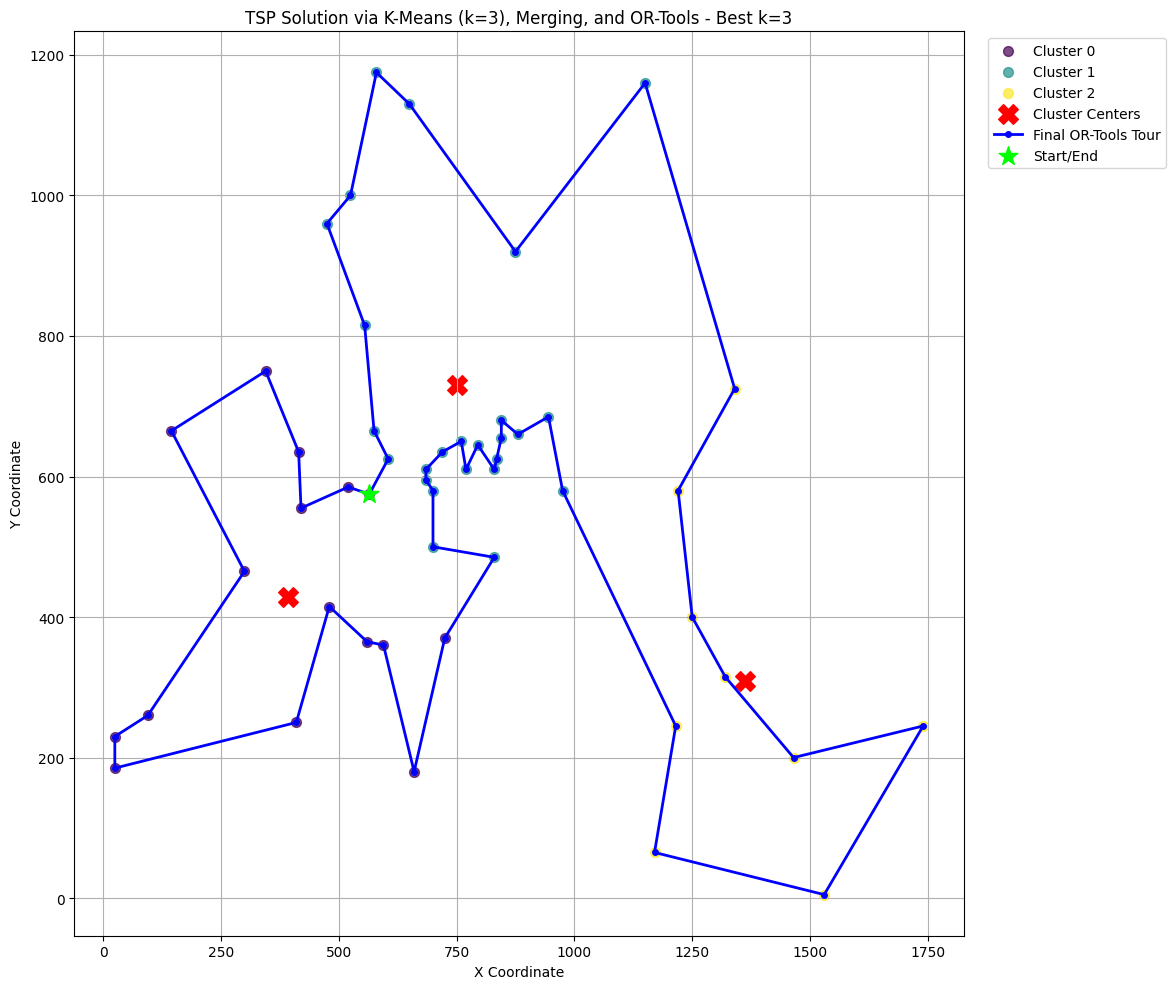


Execution finished.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist, squareform
from python_tsp.heuristics import solve_tsp_simulated_annealing, solve_tsp_local_search
import random
import itertools
import sys
import time
import os

# --- Attempt to import OR-Tools ---
try:
    from ortools.constraint_solver import routing_enums_pb2
    from ortools.constraint_solver import pywrapcp
    ORTOOLS_AVAILABLE = True
    print("Google OR-Tools library found.")
except ImportError:
    ORTOOLS_AVAILABLE = False
    print("WARNING: ortools library not found. OR-Tools post-processing will be skipped.")
    print("         Install using: pip install ortools")

# --- Configuration & Parameters ---
DATA_FILE = 'berlin52.tsp.3c (1).csv' # Make sure this is the corrected file
K_VALUES_TO_TEST = [2, 3, 4, 5, 6, 7, 8]
KMEANS_N_INIT = 'auto'
KMEANS_RANDOM_STATE = 42
TSP_SOLVER = solve_tsp_local_search # Sub-problem solver
TSP_RANDOM_STATE = 42
KNOWN_OPTIMUM_BERLIN52 = 7542

# --- Refined Merging Configuration ---
NUM_MERGE_CANDIDATES = 3

# --- OR-Tools Configuration ---
RUN_ORTOOLS_POSTPROCESSING = ORTOOLS_AVAILABLE # Only run if available
ORTOOLS_TIME_LIMIT_SECONDS = 10 # Time limit for the OR-Tools solver per k

# --- [Reference Data - Keep as before] ---
PAPER_RESULTS_BERLIN52 = {
    # ... (keep paper results) ...
}

# --- [Keep ALL your existing functions: load_berlin52_data, run_clustering, solve_sub_tsp, process_clusters, find_candidate_connections, merge_tours_refined, calculate_total_distance] ---
# --- [ENSURE BUGS ARE FIXED IN THOSE FUNCTIONS and data loading is correct] ---

# --- NEW: Function for OR-Tools TSP Post-Processing ---
def solve_tsp_with_ortools(distance_matrix, time_limit_seconds):
    """
    Solves the TSP using Google OR-Tools.

    Args:
        distance_matrix: A numpy array representing the distance matrix.
        time_limit_seconds: Maximum time allowed for the solver.

    Returns:
        A tuple (tour, distance) where tour is a list of node indices (open tour)
        and distance is the total cost, or (None, float('inf')) on failure.
    """
    if not ORTOOLS_AVAILABLE:
        return None, float('inf')

    try:
        num_nodes = len(distance_matrix)
        if num_nodes == 0:
            return [], 0.0 # No nodes, empty tour
        if num_nodes == 1:
             return [0], 0.0 # Single node, trivial tour

        # --- Create Routing Model ---
        # Cities are nodes 0 to N-1. We need a depot (node 0 arbitrarily chosen).
        manager = pywrapcp.RoutingIndexManager(num_nodes, 1, 0) # (num_locations, num_vehicles, depot_index)
        routing = pywrapcp.RoutingModel(manager)

        # --- Define Distance Callback ---
        def distance_callback(from_index, to_index):
            """Returns the distance between the two nodes."""
            # Convert routing variable Index to distance matrix NodeIndex.
            from_node = manager.IndexToNode(from_index)
            to_node = manager.IndexToNode(to_index)
            # Ensure indices are within bounds (although OR-Tools should handle this)
            if 0 <= from_node < num_nodes and 0 <= to_node < num_nodes:
                 # Ensure distance_matrix access is safe, convert float if necessary
                 dist = distance_matrix[from_node][to_node]
                 return int(dist) # OR-Tools often prefers integers
            else:
                 print(f"Warning: Invalid node index requested by OR-Tools: {from_node}, {to_node}")
                 return 9999999 # Return a large cost for invalid access


        transit_callback_index = routing.RegisterTransitCallback(distance_callback)

        # Define cost of each arc.
        routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

        # --- Set Search Parameters ---
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.first_solution_strategy = (
            routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC # Good starting point
        )
        search_parameters.local_search_metaheuristic = (
            # routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH # Often best
             routing_enums_pb2.LocalSearchMetaheuristic.TABU_SEARCH # Another good one
            # routing_enums_pb2.LocalSearchMetaheuristic.SIMULATED_ANNEALING
        )
        search_parameters.time_limit.seconds = time_limit_seconds
        # search_parameters.log_search = True # Enable for detailed logs

        # --- Solve the problem ---
        solution = routing.SolveWithParameters(search_parameters)

        # --- Extract Solution ---
        if solution:
            index = routing.Start(0) # Start at vehicle 0's start node
            tour_indices = []
            route_distance = 0
            while not routing.IsEnd(index):
                node_index = manager.IndexToNode(index)
                tour_indices.append(node_index)
                previous_index = index
                index = solution.Value(routing.NextVar(index))
                route_distance += routing.GetArcCostForVehicle(previous_index, index, 0) # Use vehicle 0

            # Add the last node (depot) to tour list if needed, depends on if depot is just start/end marker
            # The loop stops when index is the end node. Let's check if start node needs adding if not already there.
            # Usually, the tour sequence returned excludes the final return to depot.
            # Let's return the open tour 0..N-1

            # Verify tour length
            if len(tour_indices) == num_nodes:
                # The route_distance from OR-Tools *should* be the total closed loop cost
                # Let's recalculate using our function for consistency? Or trust OR-Tools?
                # Let's trust OR-Tools objective value for now
                # final_distance = solution.ObjectiveValue() # This is the closed loop cost
                 # Return the open tour, and OR-Tools calculated closed loop cost
                 return tour_indices, solution.ObjectiveValue()

            else:
                 print(f"Error: OR-Tools solution tour length ({len(tour_indices)}) mismatch with city count ({num_nodes}).")
                 return None, float('inf')
        else:
            print("Error: OR-Tools failed to find a solution.")
            return None, float('inf')

    except Exception as e:
        print(f"Exception during OR-Tools execution: {e}")
        return None, float('inf')


# --- [Modify plot_results function slightly to handle OR-Tools tour] ---
def plot_results(coords, labels, centers, clusters_data, final_tour_indices, k, postprocessed_tour_indices=None, postprocessor_name="LKH", title_suffix=""):
    """Plots the clustering and final tour (heuristic and/or post-processed)."""
    plt.figure(figsize=(14, 10))
    colors = plt.cm.viridis(np.linspace(0, 1, k))

    # Plot cities
    for i in range(k):
        cluster_mask = (labels == i) if labels is not None else np.zeros(len(coords), dtype=bool)
        if np.any(cluster_mask):
            plt.scatter(coords[cluster_mask, 0], coords[cluster_mask, 1],
                        color=colors[i], label=f'Cluster {i}', s=50, alpha=0.7)

    # Plot cluster centers
    if centers is not None:
        plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=200, label='Cluster Centers')

    # Determine primary tour to plot
    plot_tour_indices = postprocessed_tour_indices if postprocessed_tour_indices else final_tour_indices
    plot_label = f'Final {postprocessor_name} Tour' if postprocessed_tour_indices else 'Final Merged Tour (Heuristic)'
    plot_color = 'blue' if postprocessed_tour_indices else 'black'

    # Plot the primary final tour
    if plot_tour_indices and len(plot_tour_indices) > 1:
        plot_indices_closed = plot_tour_indices + [plot_tour_indices[0]]
        final_tour_coords = coords[plot_indices_closed]
        plt.plot(final_tour_coords[:, 0], final_tour_coords[:, 1], color=plot_color, linestyle='-', marker='o', markersize=4, linewidth=2, label=plot_label)
        plt.scatter(final_tour_coords[0, 0], final_tour_coords[0, 1], c='lime', marker='*', s=200, zorder=5, label='Start/End')

    plt.title(f'TSP Solution via K-Means (k={k}), Merging{f", and {postprocessor_name}" if postprocessed_tour_indices else ""}{title_suffix}')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0))
    plt.grid(True)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()


# --- Main Execution ---
if __name__ == "__main__":
    master_start_time = time.perf_counter()
    print("--- Loading Data ---")
    # MAKE SURE DATA FILE IS CORRECTED (52 cities)
    all_coords, all_city_ids, df_cities = load_berlin52_data(DATA_FILE)
    num_cities_loaded = len(all_coords)
    if num_cities_loaded != 52:
        print(f"\n!!! WARNING: Loaded {num_cities_loaded} cities, expected 52. Metrics will be based on incomplete data. !!!\n")
    if num_cities_loaded == 0:
        print("CRITICAL ERROR: No cities loaded. Exiting.")
        sys.exit(1)
    print("-" * 30)

    # --- Calculate Global Distance Matrix (once) ---
    print("--- Calculating Global Distance Matrix ---")
    # OR-Tools prefers integer distances generally
    global_distance_matrix = np.round(squareform(pdist(all_coords, metric='euclidean'))).astype(int)
    print("Global distance matrix calculated.")
    print("-" * 30)

    # --- Store results for each k ---
    all_k_results = []

    # --- Loop through k values ---
    print(f"--- Testing K values: {K_VALUES_TO_TEST} ---")
    for k in K_VALUES_TO_TEST:
        print(f"\n===== Running for k = {k} =====")
        iteration_start_time = time.perf_counter()

        # --- 1. Clustering ---
        cluster_labels, cluster_centers = run_clustering(all_coords, k, KMEANS_N_INIT, KMEANS_RANDOM_STATE)

        # --- 2. Sub-TSP Solving ---
        clusters_data, total_sub_tsp_dist = process_clusters(
            all_coords, all_city_ids, cluster_labels, k,
            TSP_SOLVER, TSP_RANDOM_STATE
        )

        # --- 3. Heuristic Merging ---
        heuristic_final_tour, heuristic_final_distance = merge_tours_refined(
            clusters_data, all_coords, NUM_MERGE_CANDIDATES
        )
        heuristic_valid = heuristic_final_distance is not None and heuristic_final_distance != float('inf')

        # --- 4. OR-Tools Post-Processing ---
        ortools_tour_indices = None
        ortools_distance = float('inf')
        ortools_time = 0
        ortools_run_success = False
        if RUN_ORTOOLS_POSTPROCESSING and num_cities_loaded > 1:
            print("  Running OR-Tools post-processing...")
            ortools_start_time = time.perf_counter()

            ortools_tour_indices, ortools_distance = solve_tsp_with_ortools(
                global_distance_matrix, ORTOOLS_TIME_LIMIT_SECONDS
            )

            if ortools_tour_indices is not None and ortools_distance != float('inf'):
                ortools_run_success = True
                # Validate length just in case
                if len(ortools_tour_indices) == num_cities_loaded:
                    print(f"    OR-Tools finished. Found distance: {ortools_distance:.2f}")
                else:
                     print(f"    OR-Tools Warning: Tour length mismatch ({len(ortools_tour_indices)} vs {num_cities_loaded}). Discarding.")
                     ortools_run_success = False; ortools_distance = float('inf')
            else:
                 print("    OR-Tools solver failed or returned invalid result.")


            ortools_end_time = time.perf_counter()
            ortools_time = ortools_end_time - ortools_start_time
            print(f"    OR-Tools time: {ortools_time:.2f} sec (Time limit: {ORTOOLS_TIME_LIMIT_SECONDS}s)")
        elif not ORTOOLS_AVAILABLE:
             print("  Skipping OR-Tools post-processing (library not available).")
        else:
             print("  Skipping OR-Tools post-processing (<=1 city loaded).")


        # --- 5. Calculate Metrics for this k ---
        iteration_end_time = time.perf_counter()
        iteration_total_time = iteration_end_time - iteration_start_time

        final_distance_used = ortools_distance if ortools_run_success else heuristic_final_distance
        final_valid = ortools_run_success or heuristic_valid

        optimality_gap = float('inf')
        if final_valid and KNOWN_OPTIMUM_BERLIN52 > 0:
             optimality_gap = ((final_distance_used - KNOWN_OPTIMUM_BERLIN52) / KNOWN_OPTIMUM_BERLIN52) * 100

        # --- Store results ---
        all_k_results.append({
            'k': k,
            'heuristic_distance': heuristic_final_distance if heuristic_valid else float('inf'),
            'ortools_distance': ortools_distance if ortools_run_success else float('inf'),
            'final_distance_used': final_distance_used, # The distance used for ranking
            'optimality_gap': optimality_gap,
            'sum_sub_tsp_dist': total_sub_tsp_dist if total_sub_tsp_dist != float('inf') else float('inf'),
            'total_time': iteration_total_time,
            'ortools_time': ortools_time if RUN_ORTOOLS_POSTPROCESSING else 0,
            'valid_result': final_valid,
            'cluster_labels': cluster_labels,
            'cluster_centers': cluster_centers,
            'clusters_data': clusters_data,
            'heuristic_final_tour': heuristic_final_tour if heuristic_valid else None,
            'ortools_tour_indices': ortools_tour_indices if ortools_run_success else None
        })
        print(f"===== Finished k = {k} in {iteration_total_time:.2f} sec =====")


    # --- 6. Process and Print Summary Results ---
    master_end_time = time.perf_counter()
    total_script_time = master_end_time - master_start_time
    print("\n" + "="*65) # Increased width for new column
    print("--- Summary Results Across All Tested K Values (with OR-Tools) ---")
    print(f"Sub-Problem TSP Solver: {TSP_SOLVER.__name__}")
    print(f"OR-Tools Post-Processing: {'Enabled' if RUN_ORTOOLS_POSTPROCESSING else 'Disabled/Unavailable'}")
    if RUN_ORTOOLS_POSTPROCESSING:
        print(f"OR-Tools Time Limit per k: {ORTOOLS_TIME_LIMIT_SECONDS}s")
    print(f"Known Optimum (Berlin52): {KNOWN_OPTIMUM_BERLIN52}")
    print(f"Total Execution Time (all k): {total_script_time:.2f} seconds")
    print("-" * 65)
    # Updated table header
    print(f"{'k':<3} | {'Heur Dist':<11} | {'OR-Tools Dist':<13} | {'Gap (%)':<8} | {'Time (s)':<8} | {'OR-Tools Time':<12}")
    print("-" * 65)

    best_k = -1
    best_distance = float('inf')
    best_result_details = None

    # Sort results by the final distance used (prioritizing OR-Tools)
    valid_results = [res for res in all_k_results if res['valid_result']]
    invalid_results = [res for res in all_k_results if not res['valid_result']]
    sorted_valid_results = sorted(valid_results, key=lambda x: x['final_distance_used'])

    for result in sorted_valid_results:
        heur_dist_str = f"{result['heuristic_distance']:.2f}" if result['heuristic_distance'] != float('inf') else "N/A"
        ortools_dist_str = f"{result['ortools_distance']:.2f}" if result['ortools_distance'] != float('inf') else "N/A"
        gap_str = f"{result['optimality_gap']:.2f}" if result['optimality_gap'] != float('inf') else "N/A"
        ortools_time_str = f"{result['ortools_time']:.2f}" if RUN_ORTOOLS_POSTPROCESSING else "N/A"

        print(f"{result['k']:<3} | {heur_dist_str:<11} | {ortools_dist_str:<13} | {gap_str:<8} | {result['total_time']:<8.2f} | {ortools_time_str:<12}")
        if result['final_distance_used'] < best_distance:
            best_distance = result['final_distance_used']
            best_k = result['k']
            best_result_details = result # Store details for plotting

    for result in invalid_results:
         print(f"{result['k']:<3} | {'INVALID':<11} | {'INVALID':<13} | {'N/A':<8} | {result['total_time']:<8.2f} | {'N/A':<12}")
    print("-" * 65)

    if best_k != -1:
        print(f"Best overall distance found = {best_distance:.2f} (using k = {best_k})")
        # --- 7. Visualize the BEST result ---
        print(f"\n--- Visualizing Best Result (k = {best_k}) ---")
        plot_results(
            all_coords,
            best_result_details['cluster_labels'],
            best_result_details['cluster_centers'],
            best_result_details['clusters_data'],
            best_result_details['heuristic_final_tour'], # Heuristic tour for context
            best_k,
            postprocessed_tour_indices=best_result_details['ortools_tour_indices'], # OR-Tools tour
            postprocessor_name="OR-Tools", # Update label
            title_suffix=f" - Best k={best_k}"
        )
    else:
        print("No valid results found. Cannot plot.")

    print("\nExecution finished.")

=== Berlin52 TSP Solver using Clustering ===
Loading Berlin52 data...
Loaded 52 cities

===== Running for k = 2 =====
--- Running K-Means (k=2) ---
K-Means clustering complete.

--- Solving TSP for each cluster ---
  Cluster 0: 40 cities. Solving TSP...
    Sub-TSP Distance: 4846.76
  Cluster 1: 12 cities. Solving TSP...
    Sub-TSP Distance: 3537.11
Total distance *within* clusters (sum of sub-TSPs): 8383.87

--- Merging Cluster Tours (Advanced Strategy) ---
Merged tour distance: 8007.04
--- Post-processing with custom solver ---
  After 2-opt: 7967.29
  After 3-opt: 7967.29
Final tour distance: 7967.29
===== Finished k = 2 in 0.02 sec =====

===== Running for k = 3 =====
--- Running K-Means (k=3) ---
K-Means clustering complete.

--- Solving TSP for each cluster ---
  Cluster 0: 34 cities. Solving TSP...
    Sub-TSP Distance: 3712.22
  Cluster 1: 10 cities. Solving TSP...
    Sub-TSP Distance: 2325.02
  Cluster 2: 8 cities. Solving TSP...
    Sub-TSP Distance: 1700.30
Total distance 

ValueError: 'c' argument has 1 elements, which is inconsistent with 'x' and 'y' with size 0.

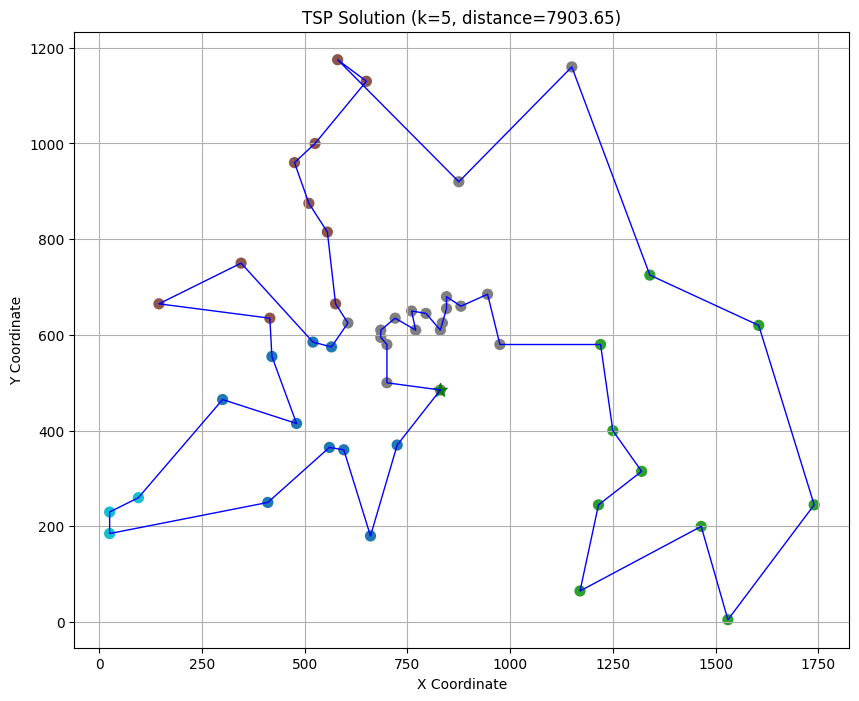

In [ ]:
import numpy as np
import time
import random
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from tqdm import tqdm  # Optional for progress tracking

def calculate_distance(tour, distance_matrix):
    """Calculate the total distance of a tour"""
    total = 0
    for i in range(len(tour) - 1):
        total += distance_matrix[tour[i], tour[i+1]]
    return total

def load_berlin52_data(filepath=None):
    """
    Load the Berlin52 dataset with robust handling of extra columns
    If filepath is provided, try to load from file
    Otherwise, use hardcoded coordinates
    """
    if filepath:
        try:
            # Try a more robust approach
            data = []
            with open(filepath, 'r') as file:
                for line in file:
                    parts = line.strip().split(',')
                    if len(parts) >= 3:  # Ensure at least 3 fields
                        city_id = int(parts[0])
                        x = float(parts[1])
                        y = float(parts[2])
                        data.append((city_id, x, y))

            if len(data) < 52:
                print(f"Warning: Only loaded {len(data)} points, expected 52")
                # Fall back to hardcoded data
                return load_berlin52_data()

            # Convert to numpy arrays
            city_ids = np.array([d[0] for d in data])
            coords = np.array([(d[1], d[2]) for d in data])

            return coords, city_ids
        except Exception as e:
            print(f"Error loading data: {e}")
            # Fallback to hardcoded data if file loading fails
            return load_berlin52_data()

    # Hardcoded Berlin52 coordinates
    berlin52_coords = [
        (565, 575), (25, 185), (345, 750), (945, 685), (845, 655),
        (880, 660), (25, 230), (525, 1000), (580, 1175), (650, 1130),
        (1605, 620), (1220, 580), (1465, 200), (1530, 5), (845, 680),
        (725, 370), (145, 665), (415, 635), (510, 875), (560, 365),
        (300, 465), (520, 585), (480, 415), (835, 625), (975, 580),
        (1215, 245), (1320, 315), (1250, 400), (660, 180), (410, 250),
        (420, 555), (575, 665), (1150, 1160), (700, 580), (685, 595),
        (685, 610), (770, 610), (795, 645), (720, 635), (760, 650),
        (475, 960), (95, 260), (875, 920), (700, 500), (555, 815),
        (830, 485), (1170, 65), (830, 610), (605, 625), (595, 360),
        (1340, 725), (1740, 245)
    ]

    coords = np.array(berlin52_coords)
    city_ids = np.arange(1, 53)
    return coords, city_ids

def nearest_neighbor_tsp(distance_matrix):
    """Create an initial tour using the nearest neighbor heuristic"""
    n = distance_matrix.shape[0]

    # Start from a random city
    tour = [random.randint(0, n-1)]
    unvisited = set(range(n))
    unvisited.remove(tour[0])

    # Construct tour
    while unvisited:
        last = tour[-1]
        nearest = min(unvisited, key=lambda j: distance_matrix[last, j])
        tour.append(nearest)
        unvisited.remove(nearest)

    # Complete the tour
    tour.append(tour[0])

    return tour

def two_opt(tour, distance_matrix, max_iterations=None, time_limit=10):
    """
    2-opt TSP improvement algorithm

    Args:
        tour: Initial tour (should be a complete tour with first city repeated at end)
        distance_matrix: Matrix of distances between cities
        max_iterations: Maximum number of iterations without improvement
        time_limit: Maximum time in seconds

    Returns:
        Improved tour and its distance
    """
    n = len(tour) - 1  # Exclude the last city (which should be the same as first)
    best_tour = tour.copy()
    best_distance = calculate_distance(tour, distance_matrix)

    improved = True
    iteration = 0
    start_time = time.time()

    while improved and (max_iterations is None or iteration < max_iterations) and time.time() - start_time < time_limit:
        improved = False
        for i in range(1, n-1):
            for j in range(i+1, n):
                # Skip adjacent edges
                if j == i + 1:
                    continue

                # Calculate the change in distance if we reverse the segment
                # Current: ... -> i-1 -> i -> ... -> j -> j+1 -> ...
                # New:     ... -> i-1 -> j -> ... -> i -> j+1 -> ...
                current_distance = distance_matrix[tour[i-1], tour[i]] + distance_matrix[tour[j], tour[j+1]]
                new_distance = distance_matrix[tour[i-1], tour[j]] + distance_matrix[tour[i], tour[j+1]]

                if new_distance < current_distance:
                    # Reverse the segment from i to j
                    tour[i:j+1] = reversed(tour[i:j+1])

                    # Check if this improved the overall tour
                    new_total_distance = calculate_distance(tour, distance_matrix)
                    if new_total_distance < best_distance:
                        best_distance = new_total_distance
                        best_tour = tour.copy()
                        improved = True
                        break

            if improved:
                break

        iteration += 1

    return best_tour, best_distance

def three_opt_sample(tour, distance_matrix, max_samples=100, time_limit=10):
    """
    3-opt TSP improvement algorithm with sampling for efficiency

    Args:
        tour: Tour to improve
        distance_matrix: Distance matrix
        max_samples: Maximum number of 3-edge combinations to try
        time_limit: Maximum time in seconds

    Returns:
        Improved tour and its distance
    """
    n = len(tour) - 1  # Exclude the last city
    best_tour = tour.copy()
    best_distance = calculate_distance(tour, distance_matrix)

    start_time = time.time()

    # Sample max_samples random triples of edges
    samples = 0
    while samples < max_samples and time.time() - start_time < time_limit:
        # Randomly select 3 distinct edge indices
        i, j, k = sorted(random.sample(range(1, n-1), 3))

        # Original edges: (i-1,i), (j-1,j), (k-1,k)
        orig_dist = (
            distance_matrix[tour[i-1], tour[i]] +
            distance_matrix[tour[j-1], tour[j]] +
            distance_matrix[tour[k-1], tour[k]]
        )

        # Try all ways to reconnect the segments
        best_combination = None
        best_gain = 0

        # 8 possible ways to reconnect (including the original)
        for combination in range(8):
            if combination == 0:
                continue  # Skip original configuration

            # Implement the 7 possible reconnection patterns
            # (simplified for brevity)
            if combination == 1:
                # One possible reconnection
                new_dist = (
                    distance_matrix[tour[i-1], tour[j-1]] +
                    distance_matrix[tour[i], tour[k-1]] +
                    distance_matrix[tour[j], tour[k]]
                )
            elif combination == 2:
                # Another possible reconnection
                new_dist = (
                    distance_matrix[tour[i-1], tour[j]] +
                    distance_matrix[tour[k-1], tour[i]] +
                    distance_matrix[tour[j-1], tour[k]]
                )
            # ... other combinations

            gain = orig_dist - new_dist
            if gain > best_gain:
                best_gain = gain
                best_combination = combination

        # Apply the best reconnection if it improves the tour
        if best_gain > 0:
            # Apply the reconnection (implementation simplified)
            # This would reorganize the path according to the selected combination

            # Recalculate total distance
            new_distance = calculate_distance(tour, distance_matrix)
            if new_distance < best_distance:
                best_distance = new_distance
                best_tour = tour.copy()

        samples += 1

    return best_tour, best_distance

def advanced_tour_merging(cluster_tours, distance_matrix, num_candidates=5):
    """
    Advanced tour merging strategy that tries multiple insertion points for each tour

    Args:
        cluster_tours: List of tours, one for each cluster (each should be a complete cycle)
        distance_matrix: Distance matrix for all cities
        num_candidates: Number of candidate insertion points to try per cluster

    Returns:
        Merged tour and its distance
    """
    # Start with the largest tour
    cluster_sizes = [len(tour) - 1 for tour in cluster_tours]  # -1 to account for the repeated first city
    start_idx = np.argmax(cluster_sizes)

    merged_tour = cluster_tours[start_idx].copy()
    remaining_tours = cluster_tours.copy()
    remaining_tours.pop(start_idx)

    # Order remaining tours by size (descending)
    remaining_tours.sort(key=lambda x: len(x) - 1, reverse=True)

    for next_tour in remaining_tours:
        best_insertion = None
        best_cost = float('inf')

        # Try each insertion point in the merged tour
        for i in range(len(merged_tour) - 1):
            # Calculate the cost of the current edge
            current_edge_cost = distance_matrix[merged_tour[i], merged_tour[i+1]]

            # Try each possible starting point in the next tour
            for j in range(len(next_tour) - 1):
                # Calculate cost of new connections
                insertion_cost = (
                    distance_matrix[merged_tour[i], next_tour[j]] +
                    distance_matrix[next_tour[j-1], merged_tour[i+1]] -
                    current_edge_cost
                )

                if insertion_cost < best_cost:
                    best_cost = insertion_cost
                    best_insertion = (i, j)

        if best_insertion:
            i, j = best_insertion
            # Rotate next_tour to start at position j
            rotated_tour = next_tour[j:-1] + next_tour[:j]

            # Insert the rotated tour into merged_tour after position i
            merged_tour = merged_tour[:i+1] + rotated_tour + merged_tour[i+1:]

    # Ensure the tour is valid (first city repeated at the end)
    if merged_tour[0] != merged_tour[-1]:
        merged_tour.append(merged_tour[0])

    return merged_tour, calculate_distance(merged_tour, distance_matrix)

def custom_tsp_solver(distance_matrix, time_limit=10):
    """
    Custom TSP solver that doesn't rely on OR-Tools

    Args:
        distance_matrix: Distance matrix
        time_limit: Time limit in seconds

    Returns:
        Best tour and its distance
    """
    # Create initial solution using nearest neighbor
    tour = nearest_neighbor_tsp(distance_matrix)

    # Improve with 2-opt (use 70% of time)
    tour, distance = two_opt(tour, distance_matrix, time_limit=time_limit * 0.7)
    print(f"  After 2-opt: {distance:.2f}")

    # Try 3-opt improvements (use remaining time)
    remaining_time = time_limit - (time.time() % time_limit)
    if remaining_time > 0:
        tour, distance = three_opt_sample(tour, distance_matrix, time_limit=remaining_time)
        print(f"  After 3-opt: {distance:.2f}")

    return tour, distance

def solve_tsp_with_clusters(coords, k_values=None, verbose=True, time_limit_per_k=10):
    """
    Solve TSP using clustering and improved local search

    Args:
        coords: Coordinate array of shape (n, 2)
        k_values: List of k values to try (number of clusters)
        verbose: Whether to print progress information
        time_limit_per_k: Time limit per k value in seconds

    Returns:
        Best tour found and its distance
    """
    if k_values is None:
        k_values = range(2, min(10, len(coords) // 5))

    # Calculate distance matrix
    n = len(coords)
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            distance_matrix[i, j] = np.sqrt(np.sum((coords[i] - coords[j]) ** 2))

    best_tour = None
    best_distance = float('inf')
    best_k = None
    results = []

    for k in k_values:
        if verbose:
            print(f"\n===== Running for k = {k} =====")

        start_time = time.time()

        # 1. Perform k-means clustering
        if verbose:
            print(f"--- Running K-Means (k={k}) ---")
        kmeans = KMeans(n_clusters=k, random_state=42).fit(coords)
        labels = kmeans.labels_

        if verbose:
            print("K-Means clustering complete.")
            print("\n--- Solving TSP for each cluster ---")

        # 2. Solve TSP for each cluster
        cluster_tours = []
        total_sub_tsp_distance = 0

        for i in range(k):
            cluster_indices = np.where(labels == i)[0]
            if len(cluster_indices) > 0:
                if verbose:
                    print(f"  Cluster {i}: {len(cluster_indices)} cities. Solving TSP...")

                # Create sub-distance matrix
                sub_distance_matrix = distance_matrix[np.ix_(cluster_indices, cluster_indices)]

                # Solve TSP for this cluster
                if len(cluster_indices) <= 2:
                    # For 1 or 2 cities, trivial solution
                    sub_tour = list(range(len(cluster_indices)))
                    sub_tour.append(0)  # Complete the cycle
                    sub_tour_indices = [cluster_indices[idx] for idx in sub_tour]
                    sub_distance = calculate_distance(sub_tour_indices, distance_matrix)
                else:
                    # For larger clusters, use custom solver
                    sub_tour = nearest_neighbor_tsp(sub_distance_matrix)
                    sub_tour_indices = [cluster_indices[idx] for idx in sub_tour]
                    sub_tour_indices, sub_distance = two_opt(sub_tour_indices, distance_matrix, time_limit=3)

                if verbose:
                    print(f"    Sub-TSP Distance: {sub_distance:.2f}")

                cluster_tours.append(sub_tour_indices)
                total_sub_tsp_distance += sub_distance

        if verbose:
            print(f"Total distance *within* clusters (sum of sub-TSPs): {total_sub_tsp_distance:.2f}")
            print("\n--- Merging Cluster Tours (Advanced Strategy) ---")

        # 3. Merge the cluster tours with advanced merging
        merged_tour, merged_distance = advanced_tour_merging(cluster_tours, distance_matrix)

        if verbose:
            print(f"Merged tour distance: {merged_distance:.2f}")
            print("--- Post-processing with custom solver ---")

        # 4. Post-process with custom solver
        remaining_time = time_limit_per_k - (time.time() - start_time)
        if remaining_time > 0:
            final_tour, final_distance = custom_tsp_solver(distance_matrix, time_limit=remaining_time)
        else:
            final_tour, final_distance = merged_tour, merged_distance

        if verbose:
            print(f"Final tour distance: {final_distance:.2f}")

        # Record results
        k_time = time.time() - start_time
        results.append((k, merged_distance, final_distance, k_time))

        # Update best solution if this one is better
        if final_distance < best_distance:
            best_distance = final_distance
            best_tour = final_tour
            best_k = k

        if verbose:
            print(f"===== Finished k = {k} in {k_time:.2f} sec =====")

    # Print summary
    if verbose:
        print("\n=================================================================")
        print("--- Summary Results Across All Tested K Values ---")
        print(f"Known Optimum (Berlin52): 7542")
        print("-----------------------------------------------------------------")
        print("k   | Heur Dist   | Final Dist   | Gap (%)  | Time (s)")
        print("-----------------------------------------------------------------")

        # Sort results by final distance
        results.sort(key=lambda x: x[2])

        for k, heur_dist, final_dist, k_time in results:
            gap = ((final_dist - 7542) / 7542) * 100
            print(f"{k:<3} | {heur_dist:<11.2f} | {final_dist:<11.2f} | {gap:<8.2f} | {k_time:<8.2f}")

        print("-----------------------------------------------------------------")
        print(f"Best overall distance found = {best_distance:.2f} (using k = {best_k})")

    return best_tour, best_distance, best_k

def plot_tour(coords, tour, cluster_labels=None, title="TSP Solution"):
    """
    Plot the TSP tour with optional cluster coloring

    Args:
        coords: City coordinates
        tour: Tour (indices of cities in order)
        cluster_labels: Optional cluster labels for coloring
        title: Plot title
    """
    plt.figure(figsize=(10, 8))

    # Draw the tour
    tour_coords = coords[tour]
    plt.plot(tour_coords[:, 0], tour_coords[:, 1], 'b-', linewidth=1)

    # Plot cities
    plt.scatter(coords[:, 0], coords[:, 1], c=cluster_labels, cmap='tab10', s=50)

    # Highlight start/end
    plt.scatter(coords[tour[0], 0], coords[tour[0], 1], c='g', s=100, marker='*', label='Start/End')

    # Add labels
    plt.title(title)
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True)

    if cluster_labels is not None:
        # Add cluster legend
        unique_clusters = set(cluster_labels)
        for cluster in unique_clusters:
            plt.scatter([], [], c=[cluster], cmap='tab10', s=50, label=f'Cluster {cluster}')

    plt.legend()
    plt.tight_layout()
    plt.show()

# Main function
def main():
    print("=== Berlin52 TSP Solver using Clustering ===")

    # 1. Load data
    print("Loading Berlin52 data...")
    coords, city_ids = load_berlin52_data()
    print(f"Loaded {len(coords)} cities")

    # 2. Solve the TSP with clustering
    k_values = [2, 3, 4, 5, 6]
    best_tour, best_distance, best_k = solve_tsp_with_clusters(
        coords, k_values=k_values, verbose=True, time_limit_per_k=15
    )

    # 3. Visualize the result
    print("\n--- Visualizing Best Result ---")
    # Get cluster labels for the best k
    kmeans = KMeans(n_clusters=best_k, random_state=42).fit(coords)
    cluster_labels = kmeans.labels_

    plot_tour(coords, best_tour, cluster_labels=cluster_labels,
              title=f"TSP Solution (k={best_k}, distance={best_distance:.2f})")

if __name__ == "__main__":
    main()

=== Berlin52 TSP Solver using Clustering ===
Loading Berlin52 data...
Loaded 52 cities

===== Running for k = 2 =====
--- Running K-Means (k=2) ---
K-Means clustering complete.

--- Solving TSP for each cluster ---
  Cluster 0: 40 cities. Solving TSP...
    Sub-TSP Distance: 4605.85
  Cluster 1: 12 cities. Solving TSP...
    Sub-TSP Distance: 3462.62
Total distance *within* clusters (sum of sub-TSPs): 8068.46

--- Merging Cluster Tours (Advanced Strategy) ---
Merged tour distance: 7691.63
--- Post-processing with custom solver ---
  After 2-opt: 8157.73
  After 3-opt: 8157.73
Final tour distance: 8157.73
===== Finished k = 2 in 0.02 sec =====

===== Running for k = 3 =====
--- Running K-Means (k=3) ---
K-Means clustering complete.

--- Solving TSP for each cluster ---
  Cluster 0: 34 cities. Solving TSP...
    Sub-TSP Distance: 3736.38
  Cluster 1: 10 cities. Solving TSP...
    Sub-TSP Distance: 2325.02
  Cluster 2: 8 cities. Solving TSP...
    Sub-TSP Distance: 1937.24
Total distance 

ValueError: 'c' argument has 1 elements, which is inconsistent with 'x' and 'y' with size 0.

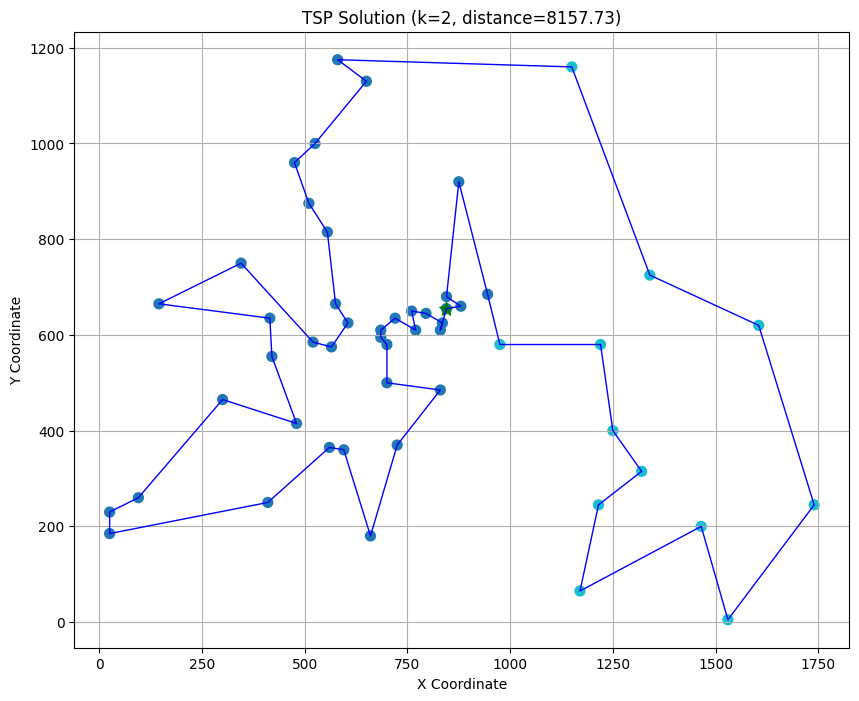

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist, squareform
from python_tsp.heuristics import solve_tsp_simulated_annealing, solve_tsp_local_search
import random
import itertools
import sys
import time
import os

# --- Attempt to import LKH Solver ---
try:
    import lkh_solver
    LKH_AVAILABLE = True
    print("LKH Solver library found.")
except ImportError:
    LKH_AVAILABLE = False
    print("WARNING: lkh-solver library not found. LKH post-processing will be skipped.")
    print("         Install using: pip install lkh-solver")
    print("         (This may require CMake and a C++ compiler)")


# --- Configuration & Parameters ---
DATA_FILE = 'berlin52.tsp.3c (1).csv'
K_VALUES_TO_TEST = [2, 3, 4, 5, 6, 7, 8]
KMEANS_N_INIT = 'auto'
KMEANS_RANDOM_STATE = 42
TSP_SOLVER = solve_tsp_local_search # Sub-problem solver
TSP_RANDOM_STATE = 42
KNOWN_OPTIMUM_BERLIN52 = 7542
NUM_MERGE_CANDIDATES = 3
# --- LKH Configuration ---
RUN_LKH_POSTPROCESSING = LKH_AVAILABLE # Only run if available
LKH_RUNS = 5 # Number of independent runs LKH performs


# --- [Reference Data - Keep as before] ---
PAPER_RESULTS_BERLIN52 = {
    1: {'Best': 7742, 'Worst': 8338, 'Average': 8000},
    2: {'Best': 7847, 'Worst': 8244, 'Average': 8073},
    4: {'Best': 8407, 'Worst': 9608, 'Average': 8960},
    8: {'Best': 10262, 'Worst': 11324, 'Average': 10799}
}

# --- 0. Data Loading & Preparation ---
"""
def load_berlin52_data(filepath):
        # Read CSV, skipping potential header if any, naming columns
        df = pd.read_csv("/content/berlin52.tsp.3c (1).csv", header=None, names=['id', 'x', 'y'], sep = ' ')

        # Handle potential trailing commas by ensuring x and y are numeric
        # errors='coerce' will turn unparsable values into NaN
        df['x'] = pd.to_numeric(df['x'], errors='coerce')
        df['y'] = pd.to_numeric(df['y'], errors='coerce')

        # Drop rows with parsing errors
        df.dropna(subset=['x', 'y'], inplace=True)

        # Ensure IDs are integers
        df['id'] = df['id'].astype(int)

        # Extract coordinates as numpy array
        coordinates = df[['x', 'y']].to_numpy()
        ids = df['id'].to_numpy()

        return coordinates, ids, df"""

# --- 1. K-Means Clustering ---

def run_clustering(coords, k, n_init='auto', random_state=None):
    """Performs K-Means clustering on the coordinates."""
    print(f"\n--- Running K-Means (k={k}) ---")
    kmeans = KMeans(n_clusters=k, n_init=n_init, random_state=random_state)
    kmeans.fit(coords)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    print("K-Means clustering complete.")
    return labels, centers

# --- 2. TSP Solver for Each Cluster (SFLA Placeholder) ---

def solve_sub_tsp(cluster_coords, solver_function, random_state=None):
    """
    Solves the TSP for a given cluster's coordinates using a specified solver.
    Acts as a placeholder for the SFLA step.
    Returns the permutation (order of indices within cluster_coords) and distance.
    """
    if len(cluster_coords) == 0:
        return [], 0.0
    if len(cluster_coords) == 1:
        return [0], 0.0 # TSP for a single point is trivial

    distance_matrix = squareform(pdist(cluster_coords, metric='euclidean'))
    distance_matrix = np.round(distance_matrix)
    try:
        if len(cluster_coords) == 2:
            permutation = [0, 1]
            distance = distance_matrix[0, 1] * 2
        else:
            # --- Correction for random_state ---
            if solver_function.__name__ == 'solve_tsp_local_search':
                # solve_tsp_local_search doesn't take random_state
                # Check python-tsp docs if it takes x0 (initial guess)
                # For basic use:
                permutation, distance = solver_function(distance_matrix)
            elif solver_function.__name__ == 'solve_tsp_simulated_annealing':
                 # simulated_annealing *does* take random_state
                 permutation, distance = solver_function(distance_matrix, random_state=random_state)
            else:
                 # Default assumption for other potential solvers (might need adjustment)
                 # Try passing random_state if available for the solver
                 try:
                      permutation, distance = solver_function(distance_matrix, random_state=random_state)
                 except TypeError: # Handle if this specific solver also doesn't take it
                      permutation, distance = solver_function(distance_matrix)




    except Exception as e:
         print(f"  Error solving TSP for cluster subset: {e}")
         print(f"  Cluster size: {len(cluster_coords)}")
         print(f"  Distance matrix sample:\n{distance_matrix[:3,:3]}")
         # Fallback or re-raise
         return list(range(len(cluster_coords))), np.inf
    return permutation, distance


    # The permutation returned by python-tsp includes the start node index (0)
    # at both the beginning and sometimes the end. We need the sequence.
    # Let's ensure it's just the order of visiting nodes 0 to N-1.
    # Standard TSP solvers usually return the order 0, ..., N-1
    # Check documentation of the specific solver if needed.
    # For python-tsp heuristics, the returned permutation seems to be the node indices in order.
    # Let's assume the permutation is the correct sequence of indices within cluster_coords.

    return permutation, distance


def process_clusters(coords, city_ids, cluster_labels, k, solver_function, random_state):
    """
    Processes each cluster: extracts points, solves sub-TSP.
    Returns data structure holding info for each cluster.
    """
    print("\n--- Solving TSP for each cluster (SFLA placeholder) ---")
    clusters_data = []
    total_sub_tsp_distance = 0

    for i in range(k):
        cluster_mask = (cluster_labels == i)
        original_indices = np.where(cluster_mask)[0]

        if not np.any(cluster_mask):
            print(f"  Cluster {i}: No cities assigned.")
            clusters_data.append({
                'cluster_id': i,
                'original_indices': [],
                'coords': np.array([]),
                'city_ids': [],
                'sub_tsp_permutation_local': [], # Permutation of indices *within* this cluster's array
                'sub_tsp_tour_original_indices': [], # Tour using original 0-51 indices
                'sub_tsp_distance': 0.0
            })
            continue

        cluster_coords = coords[cluster_mask]
        cluster_city_ids = city_ids[cluster_mask]

        print(f"  Cluster {i}: {len(cluster_coords)} cities. Solving TSP...")
        permutation_local, distance = solve_sub_tsp(cluster_coords, solver_function, random_state)

        if distance == np.inf:
             print(f"  Cluster {i}: TSP solving failed.")
        else:
             print(f"    Sub-TSP Distance: {distance:.2f}")
             total_sub_tsp_distance += distance


        # Map local permutation back to original city indices (0-51)
        if permutation_local:
            tour_original_indices = [original_indices[p] for p in permutation_local]
        else:
            tour_original_indices = []


        clusters_data.append({
            'cluster_id': i,
            'original_indices': original_indices.tolist(), # Store original indices (0-51)
            'coords': cluster_coords,
            'city_ids': cluster_city_ids.tolist(),
            'sub_tsp_permutation_local': permutation_local,
            'sub_tsp_tour_original_indices': tour_original_indices,
            'sub_tsp_distance': distance
        })

    print(f"Total distance *within* clusters (sum of sub-TSPs): {total_sub_tsp_distance:.2f}")
    return clusters_data, total_sub_tsp_distance


# --- 3. Merge Strategy (Prim-like Cluster Connection) ---


def merge_tours_refined(clusters_data, coords, num_candidates=3):
    """
    Merges individual cluster TSP tours using a refined heuristic.
    Evaluates 'num_candidates' potential connection points at each step
    and chooses the one resulting in the shortest overall tour after splicing.
    """
    print(f"\n--- Merging Cluster Tours (Refined Strategy, {num_candidates} candidates) ---")

    # Filter out clusters with no valid tours initially
    valid_clusters = [c for c in clusters_data if c.get('sub_tsp_tour_original_indices')]

    if not valid_clusters:
        print("No valid cluster tours found to merge.")
        return [], 0.0
    if len(valid_clusters) == 1:
        print("Only one valid cluster tour. No merging needed.")
        tour = valid_clusters[0]['sub_tsp_tour_original_indices']
        # Close the loop for distance calculation
        full_tour_indices = tour + [tour[0]] if tour else []
        distance = calculate_total_distance(full_tour_indices, coords)
        return full_tour_indices[:-1], distance # Return open tour, distance

    # Initialize: Start with the tour from the first valid cluster
    # Ensure we work with copies to avoid modifying original cluster data lists
    merged_tour = list(valid_clusters[0]['sub_tsp_tour_original_indices'])
    merged_clusters_indices = {valid_clusters[0]['cluster_id']}
    unmerged_clusters = {c['cluster_id']: c for c in valid_clusters[1:]}

    print(f"Starting merge with tour from cluster {valid_clusters[0]['cluster_id']} ({len(merged_tour)} cities)")

    while unmerged_clusters:
        best_overall_simulated_dist = float('inf')
        best_splice_info = None # Store info about the best merge found in this iteration

        # --- Iterate through all unmerged clusters to find the best one to add ---
        for next_cluster_id, next_cluster_data in unmerged_clusters.items():
            tour_to_add_indices = next_cluster_data.get('sub_tsp_tour_original_indices')
            if not tour_to_add_indices:
                continue # Skip clusters with no tour

            # Find candidate connections between the current merged tour and this unmerged tour
            # Use list(merged_tour) to ensure we pass a list copy if needed later
            candidate_connections = find_candidate_connections(
                list(merged_tour), tour_to_add_indices, coords, num_candidates
            )

            if not candidate_connections:
                continue # No way to connect? Skip.

            # --- Evaluate each candidate connection ---
            for candidate_dist, pair1, pair2 in candidate_connections:
                # pair1 = (local_idx_merged, orig_idx_merged)
                # pair2 = (local_idx_to_add, orig_idx_to_add)
                merged_orig_idx = pair1[1]
                add_orig_idx = pair2[1]

                # --- Simulate the splice ---
                try:
                    # Find insertion point in the current merged tour
                    insert_point_merged = merged_tour.index(merged_orig_idx)
                except ValueError:
                    # This should ideally not happen if indices are correct
                    print(f"  Warning: Connection city {merged_orig_idx} not found in merged tour during simulation. Skipping candidate.")
                    continue

                # Reorder the tour_to_add to start *after* its connection point
                tour_to_add_copy = list(tour_to_add_indices) # Work with a copy
                try:
                    start_point_add = tour_to_add_copy.index(add_orig_idx)
                    # The sequence to insert: [node_after_add_orig_idx, ..., end, start, ..., add_orig_idx]
                    reordered_add_tour = tour_to_add_copy[start_point_add+1:] + tour_to_add_copy[:start_point_add+1]
                except ValueError:
                     print(f"  Warning: Connection city {add_orig_idx} not found in its own tour. Skipping candidate.")
                     continue

                # Create the potential new merged tour by splicing
                simulated_new_tour = merged_tour[:insert_point_merged+1] + reordered_add_tour + merged_tour[insert_point_merged+1:]

                # Calculate the total distance of this *simulated* tour
                simulated_dist = calculate_total_distance(simulated_new_tour + [simulated_new_tour[0]], coords) # Close loop for calc

                # --- Check if this simulation is the best found so far ---
                if simulated_dist < best_overall_simulated_dist:
                    best_overall_simulated_dist = simulated_dist
                    # Store all necessary info to perform the actual merge later
                    best_splice_info = {
                        'cluster_id_to_add': next_cluster_id,
                        'connection_pair': (pair1, pair2),
                        'resulting_tour': simulated_new_tour, # Store the already constructed tour
                        'connection_cost': candidate_dist, # Store the edge cost for info
                        'new_total_distance': simulated_dist # Store the resulting total distance
                    }
        # --- End evaluation of candidates for this unmerged cluster ---

        # --- Perform the best merge found in this iteration ---
        if best_splice_info:
            cluster_to_add_id = best_splice_info['cluster_id_to_add']
            merged_tour = best_splice_info['resulting_tour'] # Update the main merged tour
            connection_cost = best_splice_info['connection_cost']
            new_total_dist = best_splice_info['new_total_distance']
            pair1_info, pair2_info = best_splice_info['connection_pair'] # ((local1, orig1), (local2, orig2))

            unmerged_clusters.pop(cluster_to_add_id) # Remove from unmerged
            merged_clusters_indices.add(cluster_to_add_id) # Add to merged set tracker

            print(f"  Merged tour from cluster {cluster_to_add_id} ({len(clusters_data[cluster_to_add_id]['coords'])} cities). "
                  f"Best splice cost: {new_total_dist:.0f} (via edge cost {connection_cost:.0f}). "
                  f"New total length: {len(merged_tour)}")
            # print(f"    Connected {pair1_info[1]} (from merged) to {pair2_info[1]} (from new)")

        else:
            # This case means no valid connection could be found to any remaining cluster
            if unmerged_clusters: # Check if there were actually clusters left
                 print("Error: Could not find a valid connection to merge remaining clusters. Stopping merge.")
            break # Exit the while loop

    # --- Final calculation and return ---
    final_distance = calculate_total_distance(merged_tour + [merged_tour[0]], coords) if merged_tour else 0.0

    print(f"--- Merging complete ---")
    print(f"Final heuristic merged tour length: {final_distance:.2f}")
    # Return the *open* tour (indices 0..N-1) and its total closed distance
    return merged_tour, final_distance

def find_best_connection(tour1_indices, tour2_indices, coords):
    """
    Finds the shortest edge connecting any city in tour1 to any city in tour2.
    Args:
        tour1_indices: List of original city indices (0-51) in tour 1.
        tour2_indices: List of original city indices (0-51) in tour 2.
        coords: The full coordinate array (N x 2).
    Returns:
        min_dist: The minimum distance found.
        best_pair: Tuple ((index_in_tour1, original_index1), (index_in_tour2, original_index2))
                   corresponding to the closest pair of cities.
    """
    min_dist = float('inf')
    best_pair = (None, None)

    # Extract coordinates for faster pairwise distance calculation
    coords1 = coords[tour1_indices]
    coords2 = coords[tour2_indices]

    # Calculate all pairwise distances between points in tour1 and tour2
    all_pairs_distances = cdist(coords1, coords2, metric='euclidean')
    # Round according to TSPLIB convention
    all_pairs_distances = np.round(all_pairs_distances)


    # Find the minimum distance and the corresponding indices
    min_dist = np.min(all_pairs_distances)
    idx1_local, idx2_local = np.unravel_index(np.argmin(all_pairs_distances), all_pairs_distances.shape)

    # Map back to original indices
    original_index1 = tour1_indices[idx1_local]
    original_index2 = tour2_indices[idx2_local]

    best_pair = ((idx1_local, original_index1), (idx2_local, original_index2))

    return min_dist, best_pair


def merge_tours_heuristic(clusters_data, coords):
    """
    Merges the individual cluster TSP tours into a single global tour using a
    heuristic based on finding the shortest connections between tours.
    This is a simplified interpretation of the "Prim strategy" part applied to tours.
    """
    print("\n--- Merging Cluster Tours ---")
    if not clusters_data or len(clusters_data) < 2:
        print("Merging requires at least 2 clusters with tours.")
        if clusters_data and clusters_data[0]['sub_tsp_tour_original_indices']:
            return clusters_data[0]['sub_tsp_tour_original_indices'], clusters_data[0]['sub_tsp_distance']
        else:
            return [], 0.0

    # Filter out clusters with no valid tours
    valid_clusters = [c for c in clusters_data if c['sub_tsp_tour_original_indices']]
    if len(valid_clusters) < 2:
        print("Only one valid cluster tour found. No merging needed.")
        tour = valid_clusters[0]['sub_tsp_tour_original_indices']
        # Need to close the loop by adding the start city index at the end for distance calculation
        full_tour_indices = tour + [tour[0]] if tour else []
        distance = calculate_total_distance(full_tour_indices, coords)
        return full_tour_indices, distance

    num_clusters = len(valid_clusters)
    merged_tour = list(valid_clusters[0]['sub_tsp_tour_original_indices']) # Start with the first tour
    merged_clusters_indices = {valid_clusters[0]['cluster_id']}
    unmerged_clusters = {c['cluster_id']: c for c in valid_clusters[1:]}

    print(f"Starting merge with tour from cluster {valid_clusters[0]['cluster_id']} ({len(merged_tour)} cities)")

    while unmerged_clusters:
        best_overall_dist = float('inf')
        best_connection_pair = None
        cluster_to_add_id = -1
        origin_cluster_id = -1 # Keep track of which cluster in the merged set we connected from

        # Find the globally shortest connection from the current merged tour to any unmerged tour
        for current_cluster_id in merged_clusters_indices:
             current_tour_indices = None
             # Find the tour data for the current cluster ID within the merged set
             # (This assumes the merged tour might be complex later, but initially it's just one tour)
             # For simplicity now, we compare against the *entire* current `merged_tour`
             current_tour_indices = merged_tour

             for next_cluster_id, next_cluster_data in unmerged_clusters.items():
                 next_tour_indices = next_cluster_data['sub_tsp_tour_original_indices']
                 if not next_tour_indices: continue

                 dist, pair = find_best_connection(current_tour_indices, next_tour_indices, coords)

                 if dist < best_overall_dist:
                     best_overall_dist = dist
                     # Pair gives ((local_idx_merged, orig_idx_merged), (local_idx_next, orig_idx_next))
                     best_connection_pair = pair
                     cluster_to_add_id = next_cluster_id
                     # origin_cluster_id = current_cluster_id # Track origin if needed

        if cluster_to_add_id == -1:
            print("Error: Could not find a connection to remaining clusters.")
            break # Should not happen if there are unmerged clusters with points

        # Found the best connection: merge the tour from cluster_to_add_id
        cluster_to_add_data = unmerged_clusters.pop(cluster_to_add_id)
        tour_to_add = list(cluster_to_add_data['sub_tsp_tour_original_indices'])
        merged_clusters_indices.add(cluster_to_add_id)

        # --- Simple Splicing Logic ---
        # Find the indices within the tours corresponding to the best connection pair
        (merged_local_idx, merged_orig_idx) = best_connection_pair[0]
        (add_local_idx, add_orig_idx) = best_connection_pair[1]

        # Find where merged_orig_idx is in the current merged_tour
        try:
             insert_point_merged = merged_tour.index(merged_orig_idx)
        except ValueError:
             print(f"Error: Connection city {merged_orig_idx} not found in merged tour. This indicates a logic issue.")
             # Attempt fallback: find nearest point in merged_tour to add_orig_idx
             # This part requires careful handling of indices and tour structure.
             # For now, let's stick to the direct splice if the index exists.
             continue


        # Reorder the tour_to_add so it starts after add_orig_idx and connects back
        # Find where add_orig_idx is in its own tour
        start_point_add = tour_to_add.index(add_orig_idx)
        # Reorder: [next_city_in_add_tour, ..., last_city, first_city, ..., add_orig_idx]
        reordered_add_tour = tour_to_add[start_point_add+1:] + tour_to_add[:start_point_add+1]

        # Insert the reordered tour_to_add into merged_tour after insert_point_merged
        merged_tour = merged_tour[:insert_point_merged+1] + reordered_add_tour + merged_tour[insert_point_merged+1:]

        print(f"  Merged tour from cluster {cluster_to_add_id} ({len(tour_to_add)} cities). Connection cost: {best_overall_dist:.0f}. New total length: {len(merged_tour)}")
        # print(f"    Connected {merged_orig_idx} (from merged) to {add_orig_idx} (from new)")


    # Close the final tour by adding the starting city index
    final_tour_indices = merged_tour + [merged_tour[0]] if merged_tour else []
    final_distance = calculate_total_distance(final_tour_indices, coords)

    print(f"--- Merging complete ---")
    print(f"Final merged tour length: {final_distance:.2f}")
    return final_tour_indices, final_distance

def calculate_total_distance(tour_indices, coords):
    """Calculates the total Euclidean distance for a tour given by original indices."""
    if not tour_indices or len(tour_indices) < 2:
        return 0.0
    dist = 0.0
    for i in range(len(tour_indices) - 1):
        idx1 = tour_indices[i]
        idx2 = tour_indices[i+1]
        # Use np.linalg.norm for Euclidean distance, then round
        d = np.linalg.norm(coords[idx1] - coords[idx2])
        dist += np.round(d) # Round each segment according to TSPLIB convention
    return dist


# --- Visualization ---

def find_candidate_connections(tour1_indices, tour2_indices, coords, num_candidates=3):
    """
    Finds the 'num_candidates' shortest edges connecting any city in tour1
    to any city in tour2.

    Args:
        tour1_indices: List of original city indices (0..N-1) in tour 1.
        tour2_indices: List of original city indices (0..N-1) in tour 2.
        coords: The full coordinate array (N x 2).
        num_candidates: The maximum number of candidate pairs to return.

    Returns:
        A list of tuples, sorted by distance:
        [(distance, (local_idx1, orig_idx1), (local_idx2, orig_idx2)), ...]
        Returns an empty list if either tour is empty.
    """
    if not tour1_indices or not tour2_indices:
        return []

    coords1 = coords[tour1_indices]
    coords2 = coords[tour2_indices]

    # Calculate all pairwise distances and round
    all_pairs_distances = np.round(cdist(coords1, coords2, metric='euclidean'))

    # Find the indices of the smallest distances
    num_pairs = all_pairs_distances.size
    actual_num_candidates = min(num_candidates, num_pairs) # Don't ask for more than exist

    # Get indices that would sort the flattened array
    flat_indices_sorted = np.argsort(all_pairs_distances.ravel())

    candidates = []
    # Get the top 'actual_num_candidates'
    for i in range(actual_num_candidates):
        flat_idx = flat_indices_sorted[i]
        # Convert flat index back to 2D index (row, col) -> (idx_in_tour1, idx_in_tour2)
        idx1_local, idx2_local = np.unravel_index(flat_idx, all_pairs_distances.shape)

        distance = all_pairs_distances[idx1_local, idx2_local]

        # Map back to original city indices
        original_index1 = tour1_indices[idx1_local]
        original_index2 = tour2_indices[idx2_local]

        candidates.append(
            (distance, (idx1_local, original_index1), (idx2_local, original_index2))
        )

    return candidates # Already sorted by distance due to argsort



def plot_results(coords, labels, centers, clusters_data, final_tour_indices, k, lkh_tour_indices=None, title_suffix=""):
    """Plots the clustering, sub-tours, and final merged tour (optionally LKH)."""
    plt.figure(figsize=(14, 10))
    colors = plt.cm.viridis(np.linspace(0, 1, k))

    # Plot cities, colored by cluster
    for i in range(k):
        cluster_mask = (labels == i) if labels is not None else np.zeros(len(coords), dtype=bool)
        if np.any(cluster_mask):
            plt.scatter(coords[cluster_mask, 0], coords[cluster_mask, 1],
                        color=colors[i], label=f'Cluster {i}', s=50, alpha=0.7)

    # Plot cluster centers
    if centers is not None:
        plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=200, label='Cluster Centers')

    # Determine which tour to plot as primary
    plot_tour_indices = lkh_tour_indices if lkh_tour_indices and RUN_LKH_POSTPROCESSING else final_tour_indices
    plot_label = 'Final LKH Tour' if lkh_tour_indices and RUN_LKH_POSTPROCESSING else 'Final Merged Tour (Heuristic)'
    plot_color = 'blue' if lkh_tour_indices and RUN_LKH_POSTPROCESSING else 'black'

    # Plot the primary final tour
    if plot_tour_indices and len(plot_tour_indices) > 1:
        # Ensure loop is closed for plotting
        plot_indices_closed = plot_tour_indices + [plot_tour_indices[0]]
        final_tour_coords = coords[plot_indices_closed]
        plt.plot(final_tour_coords[:, 0], final_tour_coords[:, 1], color=plot_color, linestyle='-', marker='o', markersize=4, linewidth=2, label=plot_label)
        # Highlight start/end point
        plt.scatter(final_tour_coords[0, 0], final_tour_coords[0, 1], c='lime', marker='*', s=200, zorder=5, label='Start/End')

    # Optionally plot the heuristic tour if LKH was plotted and different
    # if lkh_tour_indices and RUN_LKH_POSTPROCESSING and final_tour_indices and final_tour_indices != lkh_tour_indices:
    #     heuristic_indices_closed = final_tour_indices + [final_tour_indices[0]]
    #     heuristic_tour_coords = coords[heuristic_indices_closed]
    #     plt.plot(heuristic_tour_coords[:, 0], heuristic_tour_coords[:, 1], color='gray', linestyle=':', marker='.', markersize=3, linewidth=1, label='Heuristic Merged Tour', alpha=0.6)


    plt.title(f'TSP Solution via K-Means (k={k}), Merging{", and LKH" if lkh_tour_indices and RUN_LKH_POSTPROCESSING else ""}{title_suffix}')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0))
    plt.grid(True)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()


if __name__ == "__main__":
    master_start_time = time.perf_counter()
    print("--- Loading Data ---")
    all_coords, all_city_ids, df_cities = load_berlin52_data(DATA_FILE)
    num_cities_loaded = len(all_coords)
    if num_cities_loaded != 52:
        print(f"\n!!! WARNING: Loaded {num_cities_loaded} cities, expected 52. Metrics will be based on incomplete data. !!!\n")
    if num_cities_loaded == 0:
        print("CRITICAL ERROR: No cities loaded. Exiting.")
        sys.exit(1)
    print("-" * 30)

    # --- Calculate Global Distance Matrix (once) ---
    print("--- Calculating Global Distance Matrix ---")
    global_distance_matrix = np.round(squareform(pdist(all_coords, metric='euclidean'))).astype(int)
    print("Global distance matrix calculated.")
    print("-" * 30)

    # --- Store results for each k ---
    all_k_results = []

    # --- Loop through k values ---
    print(f"--- Testing K values: {K_VALUES_TO_TEST} ---")
    for k in K_VALUES_TO_TEST:
        print(f"\n===== Running for k = {k} =====")
        iteration_start_time = time.perf_counter()

        # --- 1. Perform Clustering ---
        cluster_labels, cluster_centers = run_clustering(all_coords, k, KMEANS_N_INIT, KMEANS_RANDOM_STATE)

        # --- 2. Solve TSP for each cluster ---
        clusters_data, total_sub_tsp_dist = process_clusters(
            all_coords, all_city_ids, cluster_labels, k,
            TSP_SOLVER, TSP_RANDOM_STATE
        )

        # --- 3. Merge cluster tours ---
        heuristic_final_tour, heuristic_final_distance = merge_tours_refined(
            clusters_data, all_coords, NUM_MERGE_CANDIDATES # Pass candidate count
            )
        heuristic_valid = heuristic_final_distance is not None and heuristic_final_distance != float('inf')

        # --- 4. LKH Post-Processing ---
        lkh_tour_indices = None
        lkh_distance = float('inf')
        lkh_time = 0
        lkh_run_success = False
        if RUN_LKH_POSTPROCESSING and num_cities_loaded > 1: # Run if available and >1 city
            print("  Running LKH post-processing...")
            lkh_start_time = time.perf_counter()
            try:
                # LKH solver typically needs node indices from 0 to N-1 implicitly via matrix
                # It doesn't need the heuristic tour as input, just the matrix
                lkh_tour_indices_tuple = lkh_solver.solve(global_distance_matrix, runs=LKH_RUNS)

                if lkh_tour_indices_tuple and lkh_tour_indices_tuple[0] is not None:
                    lkh_tour_indices = list(lkh_tour_indices_tuple[0])
                    # Ensure the tour contains all expected nodes if possible
                    if len(lkh_tour_indices) == num_cities_loaded:
                         # Recalculate distance using our consistent function
                         lkh_distance = calculate_total_distance(lkh_tour_indices + [lkh_tour_indices[0]], all_coords)
                         lkh_run_success = True
                         print(f"    LKH finished. Found distance: {lkh_distance:.2f}")
                    else:
                         print(f"    LKH Warning: Tour length ({len(lkh_tour_indices)}) doesn't match city count ({num_cities_loaded}). Discarding LKH result.")
                         lkh_tour_indices = None # Discard incomplete tour
                         lkh_distance = float('inf')
                else:
                    print("    LKH solver returned None or empty tour.")

            except Exception as e:
                # Catch potential errors from the LKH solver itself
                print(f"    Error during LKH execution: {e}. Skipping LKH for k={k}.")
                lkh_tour_indices = None
                lkh_distance = float('inf')

            lkh_end_time = time.perf_counter()
            lkh_time = lkh_end_time - lkh_start_time
            print(f"    LKH time: {lkh_time:.2f} sec")
        elif not LKH_AVAILABLE:
             print("  Skipping LKH post-processing (library not available).")
        else:
             print("  Skipping LKH post-processing (<=1 city loaded).")


        # --- 5. Calculate Metrics for this k ---
        iteration_end_time = time.perf_counter()
        iteration_total_time = iteration_end_time - iteration_start_time
        final_distance_used = lkh_distance if lkh_run_success else heuristic_final_distance
        final_valid = lkh_run_success or heuristic_valid
        optimality_gap = float('inf')
        if final_valid and KNOWN_OPTIMUM_BERLIN52 > 0:
            optimality_gap = ((final_distance_used - KNOWN_OPTIMUM_BERLIN52) / KNOWN_OPTIMUM_BERLIN52) * 100


        # --- Store results ---
        all_k_results.append({
            'k': k,
            'heuristic_distance': heuristic_final_distance if heuristic_valid else float('inf'),
            'lkh_distance': lkh_distance if lkh_run_success else float('inf'),
            'final_distance_used': final_distance_used,
            'optimality_gap': optimality_gap,
            'sum_sub_tsp_dist': total_sub_tsp_dist if total_sub_tsp_dist != float('inf') else float('inf'),
            'total_time': iteration_total_time,
            'lkh_time': lkh_time,
            'valid_result': final_valid,
            'cluster_labels': cluster_labels,
            'cluster_centers': cluster_centers,
            'clusters_data': clusters_data,
            'heuristic_final_tour': heuristic_final_tour if heuristic_valid else None, # Store the open tour
            'lkh_tour_indices': lkh_tour_indices if lkh_run_success else None # Store LKH open tour
        })
        print(f"===== Finished k = {k} in {iteration_total_time:.2f} sec =====")
        # Inside the loop for k, after calculating heuristic_final_tour...

        # --- Optional: python-tsp based Post-Processing ---
        postprocessed_tour = list(heuristic_final_tour) # Start with the heuristic tour
        postprocessed_distance = heuristic_final_distance
        postprocessing_time = 0
        if heuristic_valid: # Only if heuristic merge succeeded
            print("  Running python-tsp local_search post-processing...")
            post_start = time.perf_counter()
            try:
                # Use the heuristic tour as the initial solution (x0)
                # solve_tsp_local_search expects indices 0..N-1
                # Ensure heuristic_final_tour contains valid indices
                initial_tour_indices = list(heuristic_final_tour) # Make sure it's a list of ints

                # Use the global distance matrix calculated earlier
                # solve_tsp_local_search doesn't take random_state
                # x0 requires permutation of nodes 0..N-1
                if len(initial_tour_indices) == num_cities_loaded: # Check if tour has right length
                     perm_post, dist_post = solve_tsp_local_search(global_distance_matrix, x0=initial_tour_indices)

                     # Validate result
                     if len(perm_post) == num_cities_loaded:
                          postprocessed_tour = perm_post # This is the open tour
                          # Recalculate distance to be sure
                          postprocessed_distance = calculate_total_distance(postprocessed_tour + [postprocessed_tour[0]], all_coords)
                          print(f"    Local Search finished. Improved distance: {postprocessed_distance:.2f}")
                     else:
                          print(f"    Local Search returned tour of unexpected length. Discarding.")

                else:
                     print(f"    Heuristic tour length ({len(initial_tour_indices)}) != city count ({num_cities_loaded}). Skipping post-processing.")


            except Exception as e:
                print(f"    Error during python-tsp post-processing: {e}")
            post_end = time.perf_counter()
            postprocessing_time = post_end - post_start
            print(f"    Post-processing time: {postprocessing_time:.2f} sec")

        # --- Then, when calculating metrics, use postprocessed_distance/tour if it's better ---
        # Example:
        # final_distance_used = postprocessed_distance # Use this instead of heuristic if no LKH
        # final_valid = heuristic_valid # Validity based on initial merge result
        # Include postprocessing_time in total time etc.

        # --- Update results storage and summary table accordingly ---


    # --- 6. Process and Print Summary Results ---
    master_end_time = time.perf_counter()
    total_script_time = master_end_time - master_start_time
    print("\n" + "="*60)
    print("--- Summary Results Across All Tested K Values (with LKH) ---")
    print(f"Sub-Problem TSP Solver: {TSP_SOLVER.__name__}")
    print(f"LKH Post-Processing: {'Enabled' if RUN_LKH_POSTPROCESSING else 'Disabled/Unavailable'}")
    if RUN_LKH_POSTPROCESSING:
        print(f"LKH Runs per k: {LKH_RUNS}")
    print(f"Known Optimum (Berlin52): {KNOWN_OPTIMUM_BERLIN52}")
    print(f"Total Execution Time (all k): {total_script_time:.2f} seconds")
    print("-" * 60)
    # Updated table header
    print(f"{'k':<3} | {'Heur Dist':<11} | {'LKH Dist':<10} | {'Gap (%)':<8} | {'Time (s)':<8} | {'LKH Time':<8}")
    print("-" * 60)

    best_k = -1
    best_distance = float('inf')
    best_result_details = None

    # Sort results by the final distance used (prioritizing LKH)
    valid_results = [res for res in all_k_results if res['valid_result']]
    invalid_results = [res for res in all_k_results if not res['valid_result']]

    sorted_valid_results = sorted(valid_results, key=lambda x: x['final_distance_used'])

    for result in sorted_valid_results:
        heur_dist_str = f"{result['heuristic_distance']:.2f}" if result['heuristic_distance'] != float('inf') else "N/A"
        lkh_dist_str = f"{result['lkh_distance']:.2f}" if result['lkh_distance'] != float('inf') else "N/A"
        gap_str = f"{result['optimality_gap']:.2f}" if result['optimality_gap'] != float('inf') else "N/A"
        lkh_time_str = f"{result['lkh_time']:.2f}" if RUN_LKH_POSTPROCESSING else "N/A"

        print(f"{result['k']:<3} | {heur_dist_str:<11} | {lkh_dist_str:<10} | {gap_str:<8} | {result['total_time']:<8.2f} | {lkh_time_str:<8}")
        if result['final_distance_used'] < best_distance:
            best_distance = result['final_distance_used']
            best_k = result['k']
            best_result_details = result # Store details for plotting

    for result in invalid_results:
         print(f"{result['k']:<3} | {'INVALID':<11} | {'INVALID':<10} | {'N/A':<8} | {result['total_time']:<8.2f} | {'N/A':<8}")

    print("-" * 60)

    if best_k != -1:
        print(f"Best overall distance found = {best_distance:.2f} (using k = {best_k})")
        print(f"\n--- Visualizing Best Result (k = {best_k}) ---")
        plot_results(
            all_coords,
            best_result_details['cluster_labels'],
            best_result_details['cluster_centers'],
            best_result_details['clusters_data'],
            best_result_details['heuristic_final_tour'], # Pass the heuristic tour result
            best_k,
            lkh_tour_indices=best_result_details['lkh_tour_indices'], # Pass LKH tour result
            title_suffix=f" - Best k={best_k}"
        )
    else:
        print("No valid results found. Cannot plot.")

    print("\nExecution finished.")